# MSE and MAE Implementation

In this notebook, we implement `Mean Squared Error (MSE)` and `Mean Absolute Error (MAE)` 
as well as observe that `MAE` is more robust to outlier compare to `MSE`.

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
torch.manual_seed(0)

## 1. Generate Data

We will generate 1000 data points for the experiment. The `x` axis is the independent
variable which has values randomly distributed between -5 to 5. We assume some values 
for `m` and `c` to create the data points for the dependent variable (`y`-axis).
We also add randomness so that the `y` value are different for the same `x`.

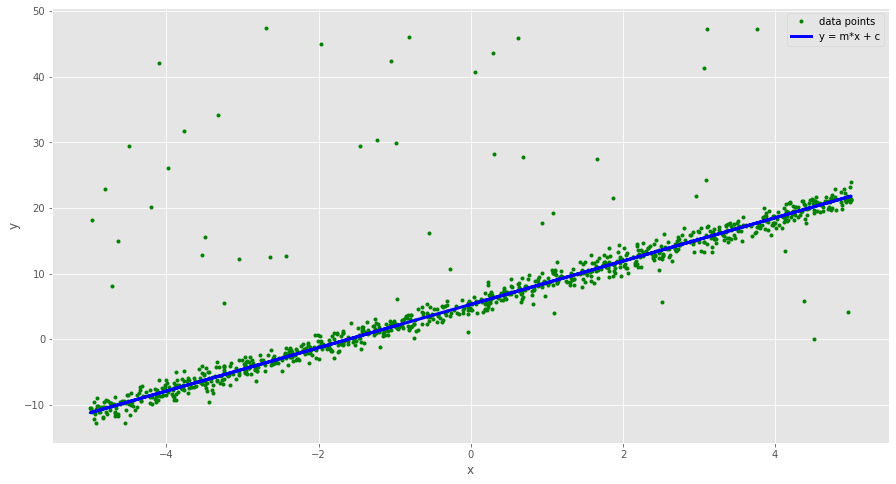

In [3]:
# Generate y = mx + c + random noise
n_data = 1000

# True value of m and c
m_line = 3.3
c_line = 5.3

# Generate random data x in range [-5, 5]
x = 10 * torch.rand(n_data) - 5

# Generate data y = mx + c + noise
y = m_line * x + c_line + torch.randn_like(x)

# Add more outlier

n_outliers = int(0.05 * n_data)
random_index = torch.randint(n_data, (n_outliers,))
y[random_index] = 50 * torch.rand(len(random_index))

# The line
y_line = m_line * x + c_line

# Plot the generated data points
plt.plot(x, y, '.', color='g', label='data points')
plt.plot(x, y_line, color='b', label='y = m*x + c', linewidth=3)
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()

## 2. Problem Formulation

The goal is to predict $y$ given some value of $x$. To do this we will fit a line 
that goes through the data points $(x_{i}, y_{i})$. The equation for such a line is

\begin{equation}
y = mx + c
\end{equation}

We have a set of data points $(x_{i}, y_{i})$, and they should all satisfy the equation 
above. i.e.,

\begin{equation}
y_{i} = mx_{i} + c
\end{equation}

Because the data having noise, th best $m$ and $c$ we can find will not fit the 
data perfectly. So, we will have an **error** or **residual** given by

\begin{equation}
e_{i} = (y_{i} - mx_{i} - c)
\end{equation}

To find the optimal value of $m$ and $c$, we will minimize the error above or minimize 
the squared or absolute of the error aboce instead.

## 3. Loss Functions and their Gradients w.r.t Leanring Parameters

### 3.1. Mean Squared Error (MSE)

The `Mean Squared Error (MSE)` function is given by:

\begin{equation}
l_{mse} = \frac{1}{N}\sum^{N}_{i=1}(y_{i} - mx_{i} - c)^{2}
\end{equation}

The partial derivatives w.r.t `m` and `c` respectively:

\begin{equation}
\frac{\partial l_{mse}}{\partial m} = 
-\frac{2}{N}\sum^{N}_{i=1}x_{i}(y_{i} - mx_{i} - c)
\end{equation}

\begin{equation}
\frac{\partial l_{mse}}{\partial c} = 
-\frac{2}{N}\sum^{N}_{i=1}(y_{i} - mx_{i} - c)
\end{equation}

Update rule of `m` and `c` using gradient descent with learning rate $\lambda$:

\begin{equation}
m_{k} = m_{k - 1} - \lambda\frac{\partial l_mse}{\partial m}
\end{equation}

\begin{equation}
c_{k} = c_{k - 1} - \lambda\frac{\partial l_mse}{\partial c}
\end{equation}

#### MSE Loss Implementation

In [4]:
def MSE_loss(inputs, labels, m, c):
    e = labels - m * inputs - c
    mse = torch.sum(e * e) / float(len(labels))
    return mse

In [5]:
X = torch.tensor([-0.0374, 2.6822, -4.1152])
Y = torch.tensor([5.1765, 14.1513, -8.2802])
m = 2
c = 3

mse_loss = MSE_loss(X, Y, m, c)

print('Mean Squared Error (MSE): {:.2f}'.format(mse_loss))

Mean Squared Error (MSE): 15.95


#### Implementation of Gradient for MSE

In [6]:
def gradient_m_and_c_mse(inputs, labels, m, c):
    e = labels - m * inputs - c
    g_m = -2 * torch.sum(e * inputs) / float(len(labels))
    g_c = -2 * torch.sum(e) / float(len(labels))
    return g_m, g_c

In [7]:
X = torch.tensor([-0.0374, 2.6822, -4.1152])
Y = torch.tensor([5.1765, 14.1513, -8.2802])
m = 2
c = 3

g_m, g_c = gradient_m_and_c_mse(X, Y, m, c)

print('Gradient w.r.t m (for MSE): {:.2f}'.format(g_m))
print('Gradient w.r.t c (for MSE): {:.2f}'.format(g_c))

Gradient w.r.t m (for MSE): -18.66
Gradient w.r.t c (for MSE): -3.33


### 3.2. Mean Absolute Error (MAE)

The `Mean Absolute Error (MAE)` function is given by:

\begin{equation}
l_{mae} = \frac{1}{N}\sum^{N}_{i=1}\mid y_{i} - mx_{i} - c \mid
\end{equation}

The above function can be re-written as the following:

\begin{equation}
l_{mae} = \frac{1}{N}\sum^{N}_{i=1}sign(y_{i} - mx_{i} - c)\cdot(y_{i} - mx_{i} - c)
\end{equation}

where

\begin{equation}
sign(x) = 
\begin{cases}
1 & \text{if } x > 0 \\
-1 & \text{if } x < 0 \\
0 & \text{otherwise}
\end{cases}
\end{equation}

The partial derivatives w.r.t `m` and `c` respectively:

\begin{equation}
\frac{\partial l_{mae}}{\partial m}  = -\frac{1}{N}\sum^{N}_{i=1}sign(y_{i} - mx_{i} - c)\cdot x_{i} \\
\frac{\partial l_{mae}}{\partial c}  = -\frac{1}{N}\sum^N_{i=1}sign(y_{i} - mx_{i} - c) \\                      
\end{equation}

Update rule of `m` and `c` using gradient descent with learning rate $\lambda$:

\begin{equation}
m_{k} = m_{k-1} - \lambda\frac{\partial l_{mae}}{\partial m} \\
c_{k} = c_{k-1} - \lambda\frac{\partial l_{mae}}{\partial c} \\ 
\end{equation}

#### Implementation of MAE

In [8]:
def MAE_loss(inputs, labels, m, c):
    e = labels - m * inputs - c
    mae = torch.sum(torch.sign(e) * e) / float(len(labels))
    return mae

In [9]:
X = torch.tensor([-0.0374, 2.6822, -4.1152])
Y = torch.tensor([5.1765, 14.1513, -8.2802])
m = 2
c = 3

mae_loss = MAE_loss(X, Y, m, c)

print('Mean Absolute Error (MAE): {:.2f}'.format(mae_loss))

Mean Absolute Error (MAE): 3.70


#### Implementatio of Gradient for MAE

In [10]:
def gradient_m_and_c_mae(inputs, labels, m, c):
    e = labels - m * inputs - c
    g_m = -torch.sum(torch.sign(e) * inputs) / float(len(labels))
    g_c = -torch.sum(torch.sign(e)) / float(len(labels))
    return g_m, g_c

In [11]:
X = torch.tensor([-0.0374, 2.6822, -4.1152])
Y = torch.tensor([5.1765, 14.1513, -8.2802])
m = 2
c = 3

g_m, g_c = gradient_m_and_c_mae(X, Y, m, c)

print('Gradient w.r.t m (for MAE): {:.2f}'.format(g_m))
print('Gradient w.r.t c (for MAE): {:.2f}'.format(g_c))

Gradient w.r.t m (for MAE): -2.25
Gradient w.r.t c (for MAE): -0.33


## 4. Training with SGD and minibatch

Update m and c.

In [12]:
def update_m_and_c(m, c, g_m, g_c, lr):
    m = m - lr * g_m
    c = c - lr * g_c
    return m, c

Function for loss plot.

In [13]:
def plot_loss(loss):
    plt.subplot(1, 2, 1)
    plt.plot(range(len(loss[0])), loss[0], color='k')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.title('MSE Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(loss[1])), loss[1], color='r')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.title('MAE Loss')
    
    plt.show()

Function for display intermediate training

In [14]:
def display_training(X, Y, Y_line, loss, m, c, iteration):
    print('Iteration: {}, \nMSE Loss: {:.3f}, m_mse: {:.3f}, m_mse: {:.3f}'.format(
        iteration, loss[0][-1], m[0], c[0]))
    print('Iteration: {}, \nMAE Loss: {:.3f}, m_mae: {:.3f}, m_mae: {:.3f}'.format(
        iteration, loss[1][-1], m[1], c[1]))
    
    y_pred_mse = m[0] * X + c[0]
    y_pred_mae = m[1] * X + c[1]
    
    # Points plot
    plt.plot(X, Y, '.', color='g')
    # Line for which data is generated
    plt.plot(X, Y_line, color='b', label='Line corresponding to m={:.2f}, c={:.2f}'.format(
        m_line, c_line), linewidth=3)
    # Line learned with MSE loss
    plt.plot(X, y_pred_mse, color='k', label='Line corresponding to m={:.2f}, c={:.2f}'.format(
        m[0], c[0]), linewidth=3)
    # Line learned with MAE loss
    plt.plot(X, y_pred_mae, color='r', label='Line corresponding to m={:.2f}, c={:.2f}'.format(
        m[1], c[1]), linewidth=3)
    plt.title('Iteration: {}'.format(iteration))
    plt.legend()
    
    plt.ylabel('y')
    plt.xlabel('x')
    plt.show()
    

Function for training.

In [15]:
def train(inputs, labels, labels_line, 
          initial_m, initial_c, 
          grad_func_list, loss_func_list,
          lr=0.01, batch_size=10, epoch=10, display_count=20):
    loss = {}
    m = {}
    c = {}
    
    for i in range(len(grad_func_list)):
        loss[i] = []
        m[i] = initial_m
        c[i] = initial_c
        
    n_batches = int(len(inputs) / batch_size)
    
    for i in range(epoch):
        shuffle_indices = torch.randint(0, len(inputs), (len(inputs),))
        for j in range(n_batches):
            X = inputs[shuffle_indices[j * batch_size : j * batch_size + batch_size]]
            Y = labels[shuffle_indices[j * batch_size : j * batch_size + batch_size]]
            
            for k, grad_m_c in enumerate(grad_func_list):
                g_m, g_c = grad_m_c(X, Y, m[k], c[k])
                m[k], c[k] = update_m_and_c(m[k], c[k], g_m, g_c, lr)
                l = loss_func_list[k](inputs, labels, m[k], c[k])
                loss[k].append(l)
            
            if j % display_count == 0:
                iteration = i * n_batches + j
                display_training(inputs, labels, labels_line, loss, m, c, iteration)
    final_iteration = (epoch - 1) * n_batches + n_batches - 1
    return m, c, loss, final_iteration

Training.

Iteration: 0, 
MSE Loss: 67.907, m_mse: 2.152, m_mse: 1.049
Iteration: 0, 
MAE Loss: 5.734, m_mae: 2.009, m_mae: 1.003


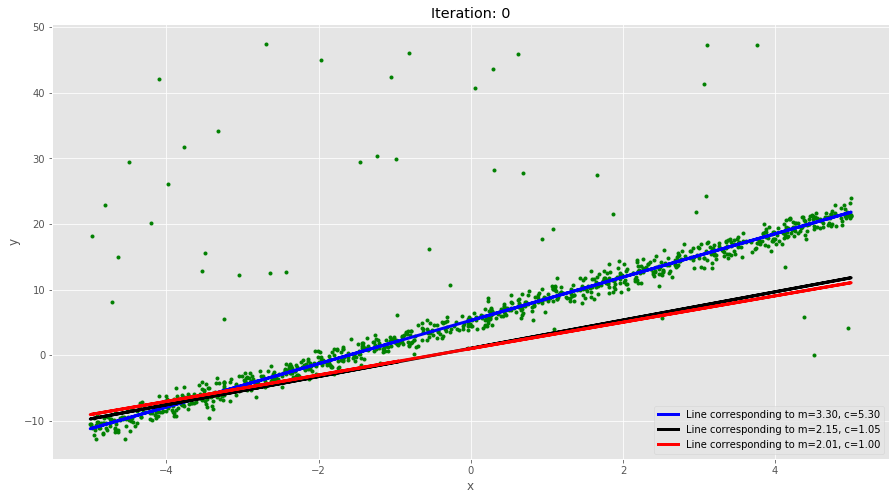

Iteration: 40, 
MSE Loss: 46.865, m_mse: 3.064, m_mse: 2.613
Iteration: 40, 
MAE Loss: 5.393, m_mae: 2.233, m_mae: 1.146


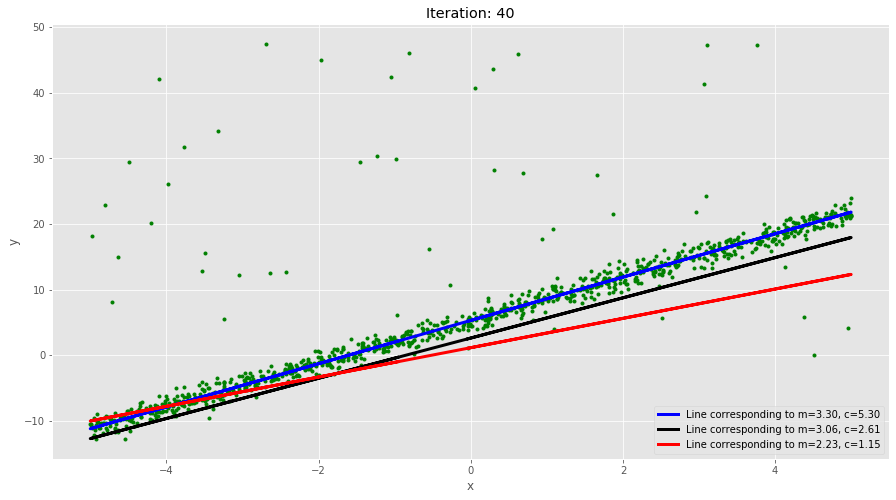

Iteration: 80, 
MSE Loss: 38.914, m_mse: 3.091, m_mse: 3.942
Iteration: 80, 
MAE Loss: 5.145, m_mae: 2.396, m_mae: 1.301


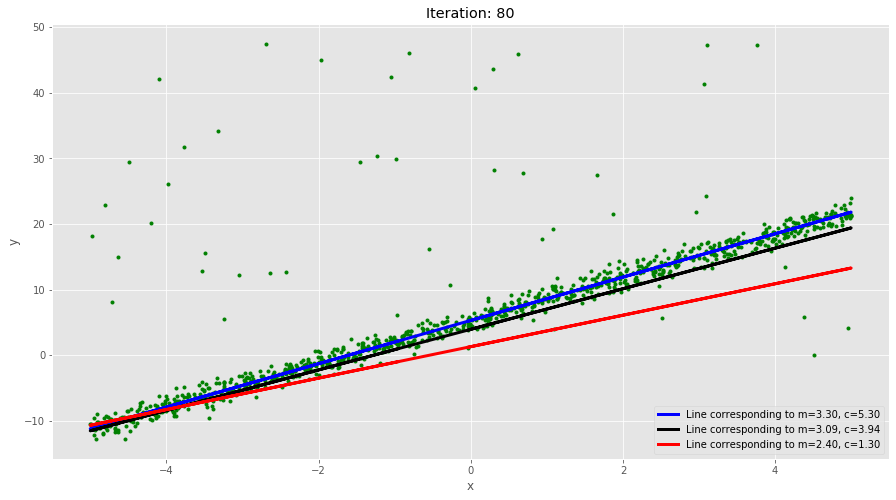

Iteration: 100, 
MSE Loss: 36.816, m_mse: 2.920, m_mse: 4.492
Iteration: 100, 
MAE Loss: 5.028, m_mae: 2.480, m_mae: 1.390


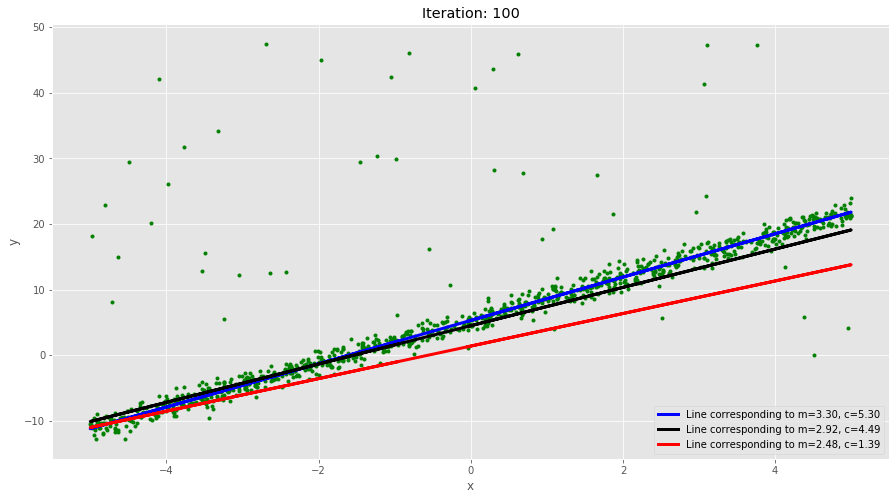

Iteration: 140, 
MSE Loss: 35.186, m_mse: 2.904, m_mse: 5.047
Iteration: 140, 
MAE Loss: 4.857, m_mae: 2.514, m_mae: 1.567


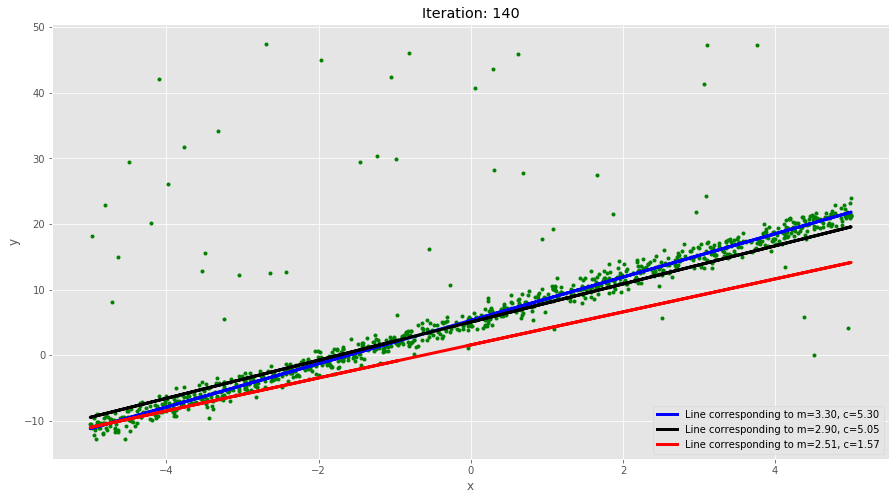

Iteration: 180, 
MSE Loss: 34.850, m_mse: 3.310, m_mse: 5.354
Iteration: 180, 
MAE Loss: 4.658, m_mae: 2.620, m_mae: 1.747


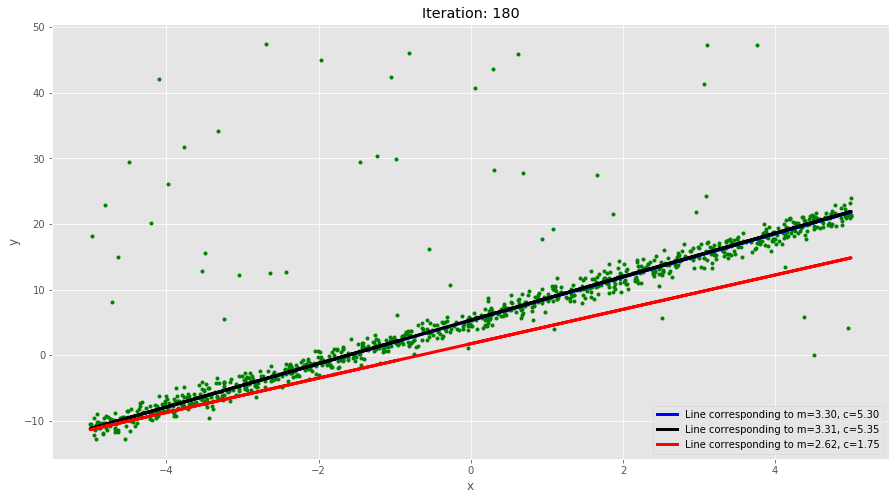

Iteration: 200, 
MSE Loss: 35.332, m_mse: 2.662, m_mse: 5.565
Iteration: 200, 
MAE Loss: 4.589, m_mae: 2.607, m_mae: 1.828


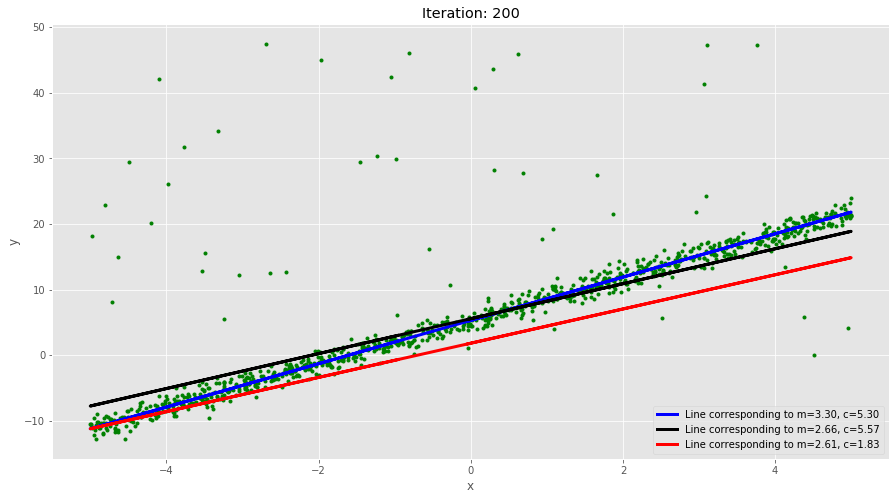

Iteration: 240, 
MSE Loss: 33.756, m_mse: 3.057, m_mse: 5.740
Iteration: 240, 
MAE Loss: 4.425, m_mae: 2.659, m_mae: 1.991


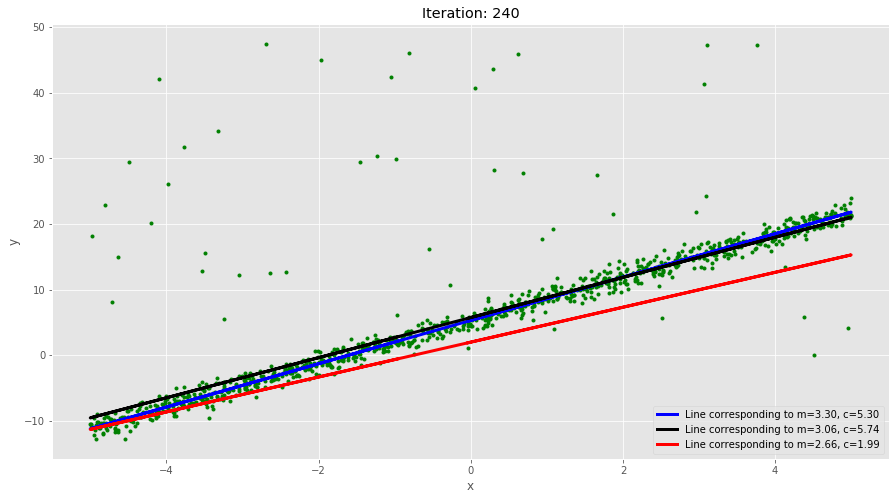

Iteration: 280, 
MSE Loss: 33.826, m_mse: 2.904, m_mse: 5.893
Iteration: 280, 
MAE Loss: 4.234, m_mae: 2.751, m_mae: 2.170


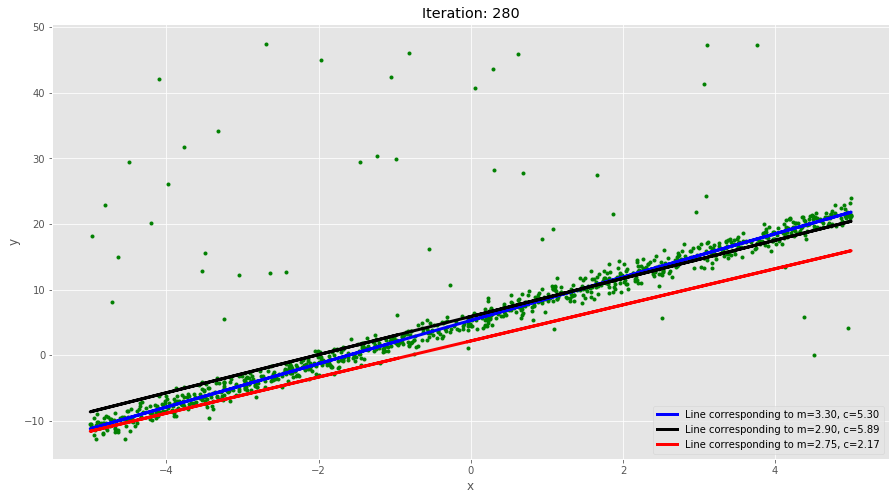

Iteration: 300, 
MSE Loss: 33.683, m_mse: 3.194, m_mse: 6.034
Iteration: 300, 
MAE Loss: 4.134, m_mae: 2.808, m_mae: 2.263


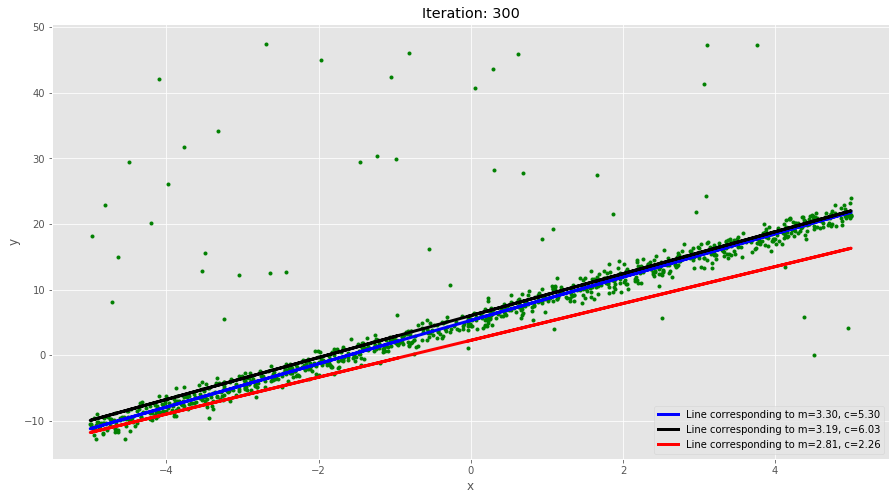

Iteration: 340, 
MSE Loss: 33.481, m_mse: 3.036, m_mse: 6.216
Iteration: 340, 
MAE Loss: 3.945, m_mae: 2.871, m_mae: 2.454


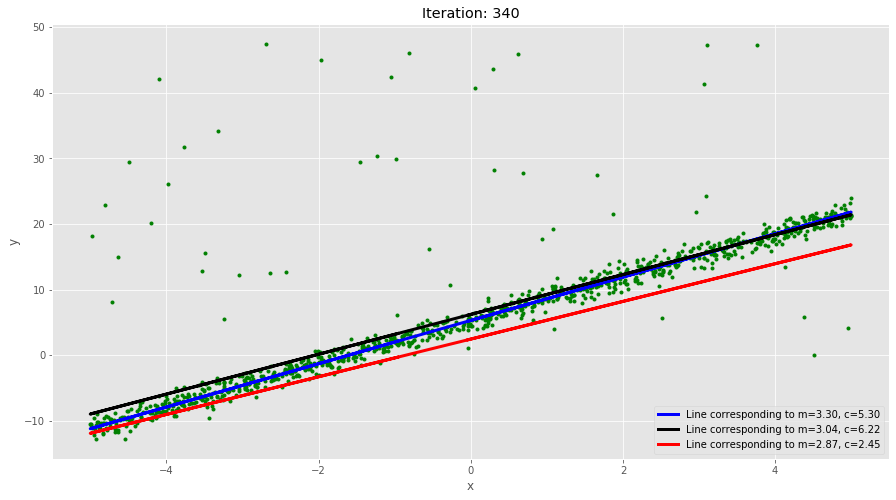

Iteration: 380, 
MSE Loss: 33.510, m_mse: 2.993, m_mse: 6.280
Iteration: 380, 
MAE Loss: 3.759, m_mae: 2.935, m_mae: 2.640


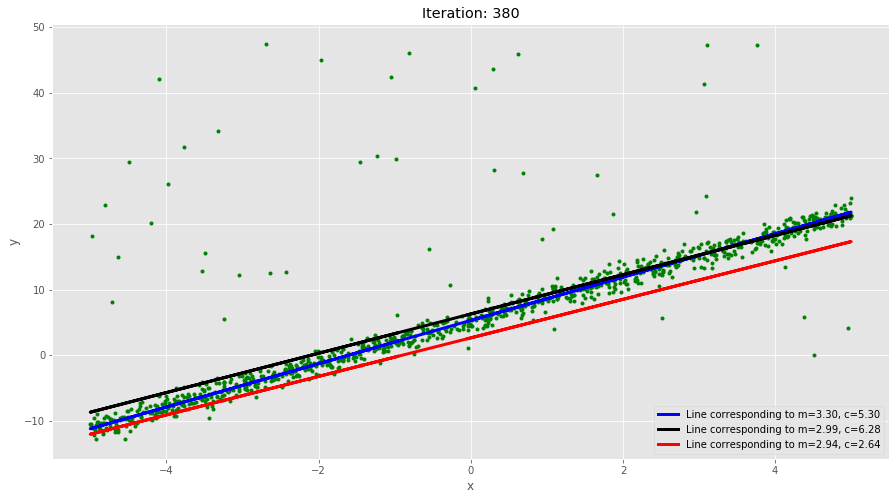

Iteration: 400, 
MSE Loss: 33.522, m_mse: 2.984, m_mse: 6.268
Iteration: 400, 
MAE Loss: 3.667, m_mae: 2.975, m_mae: 2.732


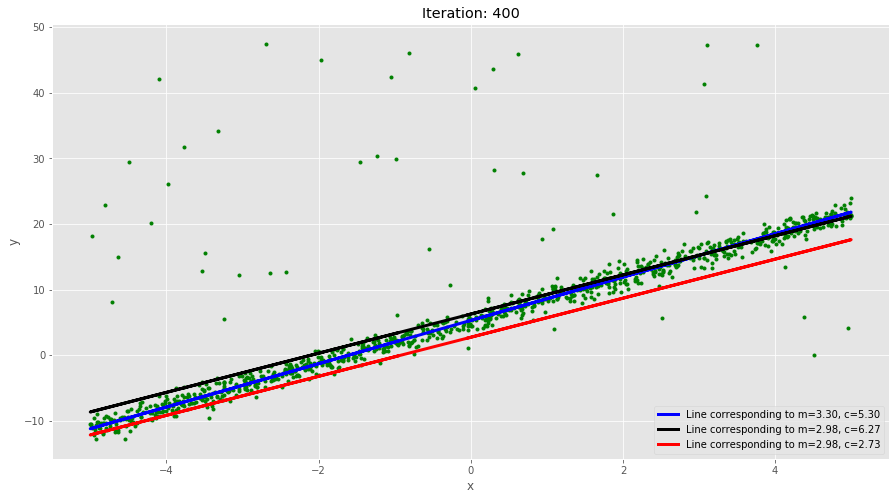

Iteration: 440, 
MSE Loss: 33.568, m_mse: 3.164, m_mse: 6.311
Iteration: 440, 
MAE Loss: 3.492, m_mae: 2.996, m_mae: 2.917


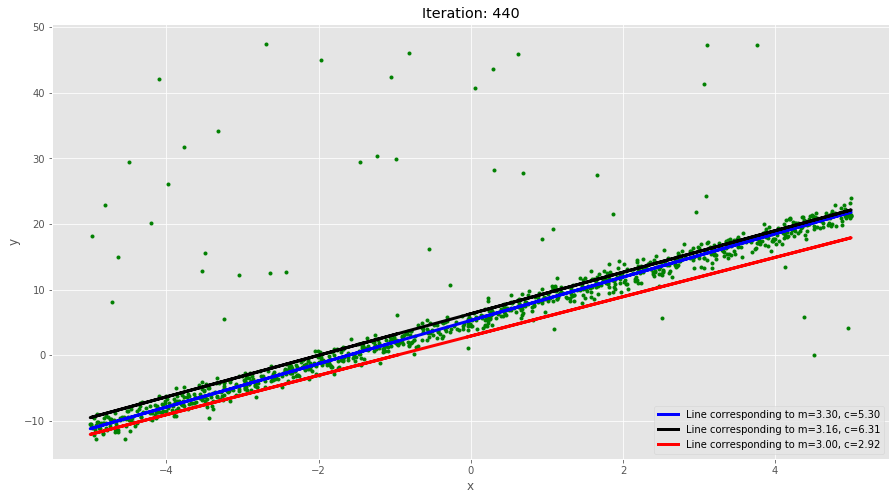

Iteration: 480, 
MSE Loss: 33.498, m_mse: 3.096, m_mse: 6.390
Iteration: 480, 
MAE Loss: 3.318, m_mae: 3.008, m_mae: 3.105


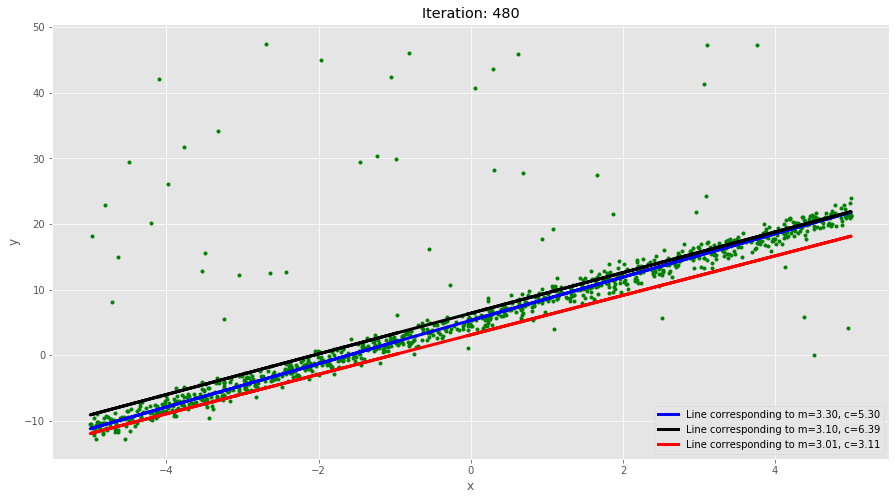

Iteration: 500, 
MSE Loss: 33.584, m_mse: 2.950, m_mse: 6.364
Iteration: 500, 
MAE Loss: 3.236, m_mae: 3.013, m_mae: 3.194


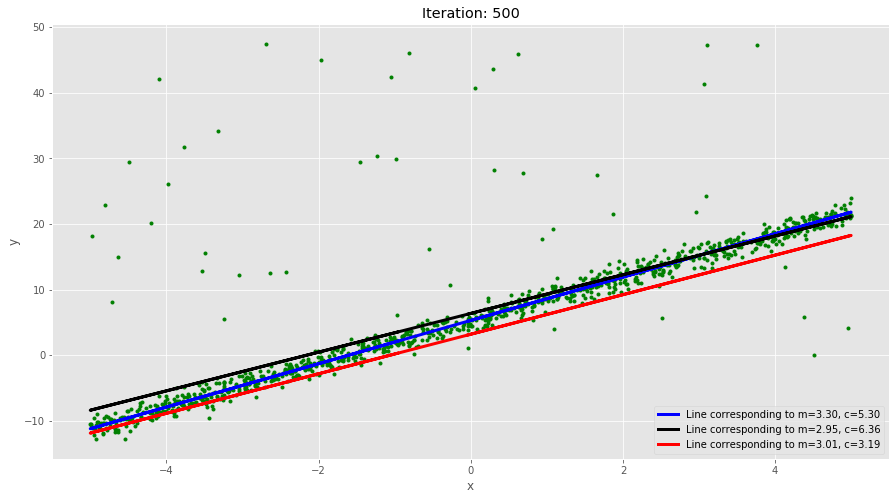

Iteration: 540, 
MSE Loss: 33.656, m_mse: 2.940, m_mse: 6.519
Iteration: 540, 
MAE Loss: 3.063, m_mae: 3.035, m_mae: 3.380


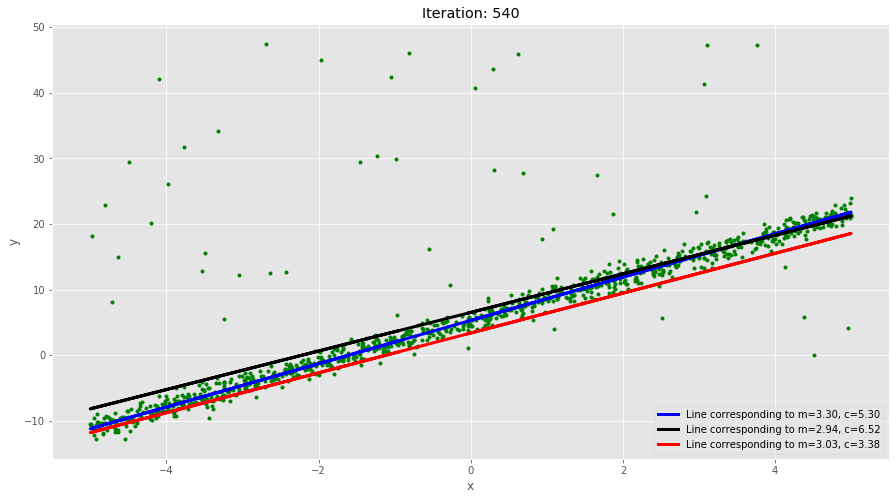

Iteration: 580, 
MSE Loss: 33.612, m_mse: 3.185, m_mse: 6.341
Iteration: 580, 
MAE Loss: 2.896, m_mae: 3.082, m_mae: 3.553


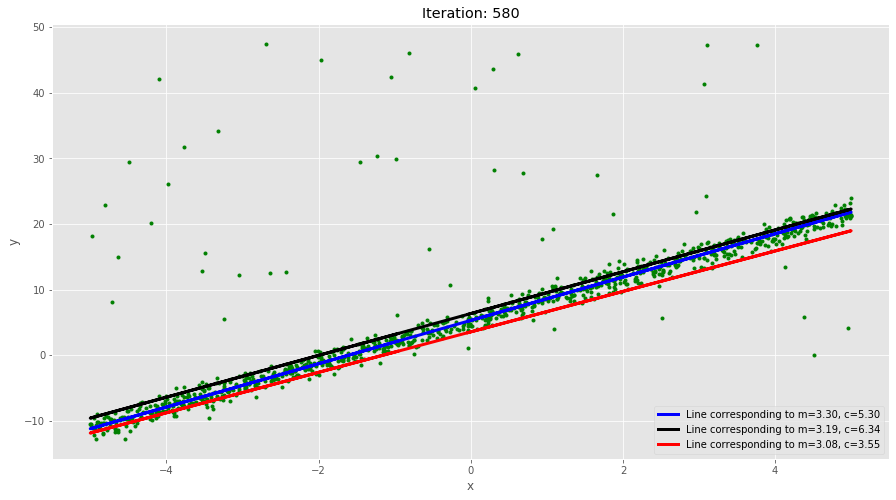

Iteration: 600, 
MSE Loss: 33.539, m_mse: 3.148, m_mse: 6.272
Iteration: 600, 
MAE Loss: 2.820, m_mae: 3.080, m_mae: 3.641


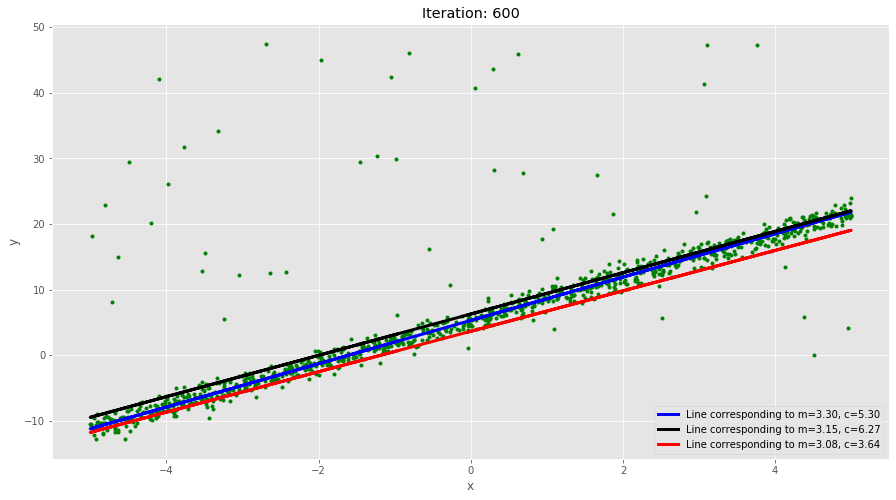

Iteration: 640, 
MSE Loss: 33.693, m_mse: 2.904, m_mse: 6.390
Iteration: 640, 
MAE Loss: 2.672, m_mae: 3.092, m_mae: 3.812


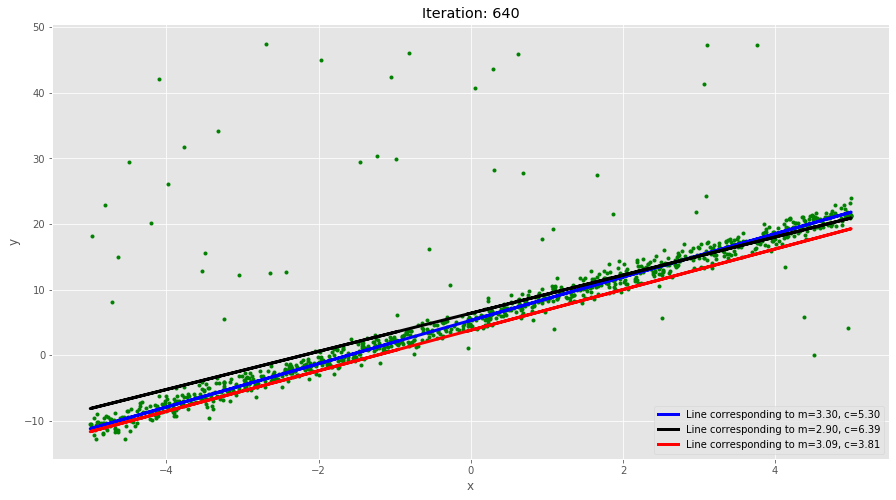

Iteration: 680, 
MSE Loss: 33.480, m_mse: 3.072, m_mse: 6.352
Iteration: 680, 
MAE Loss: 2.519, m_mae: 3.160, m_mae: 3.972


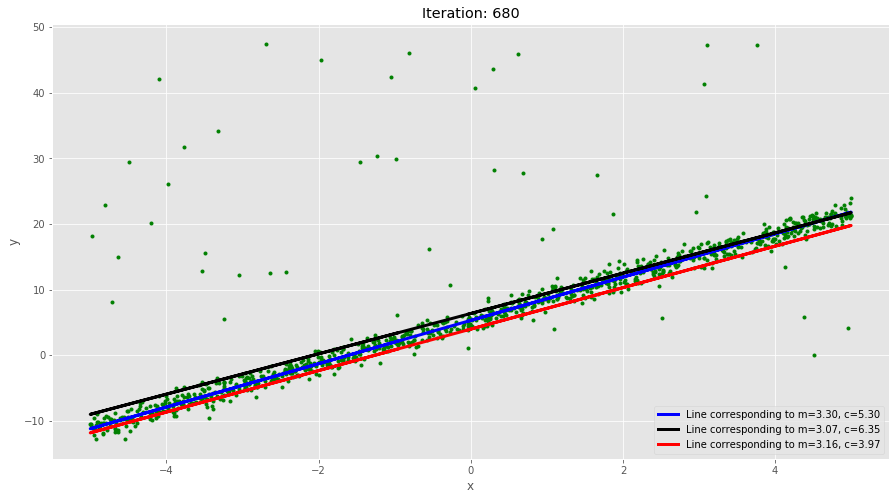

Iteration: 700, 
MSE Loss: 33.474, m_mse: 3.068, m_mse: 6.295
Iteration: 700, 
MAE Loss: 2.447, m_mae: 3.206, m_mae: 4.050


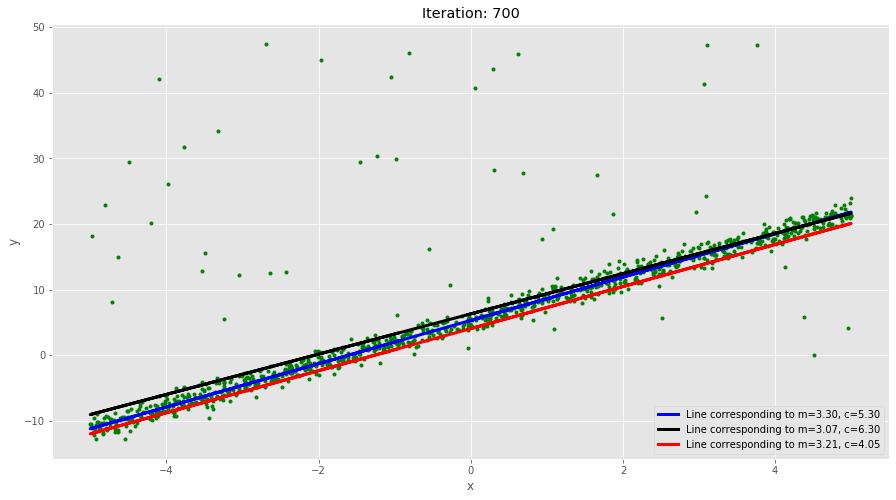

Iteration: 740, 
MSE Loss: 33.516, m_mse: 3.056, m_mse: 6.480
Iteration: 740, 
MAE Loss: 2.324, m_mae: 3.209, m_mae: 4.207


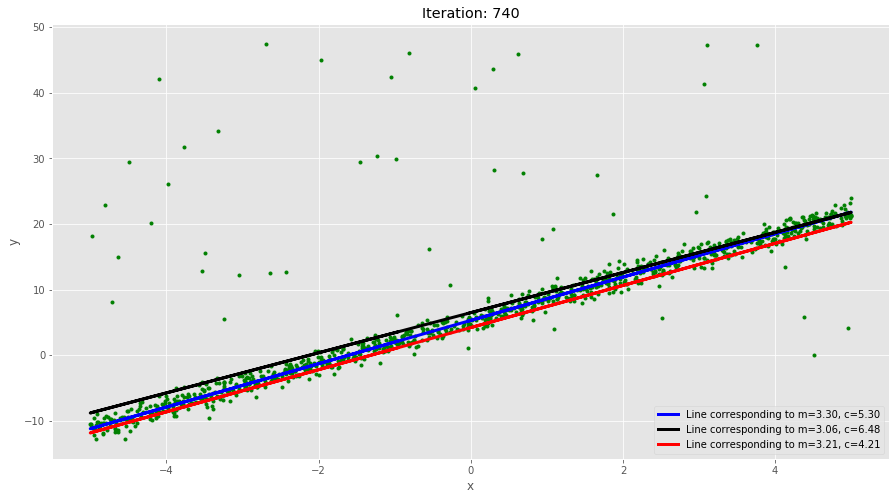

Iteration: 780, 
MSE Loss: 33.683, m_mse: 2.908, m_mse: 6.389
Iteration: 780, 
MAE Loss: 2.214, m_mae: 3.254, m_mae: 4.348


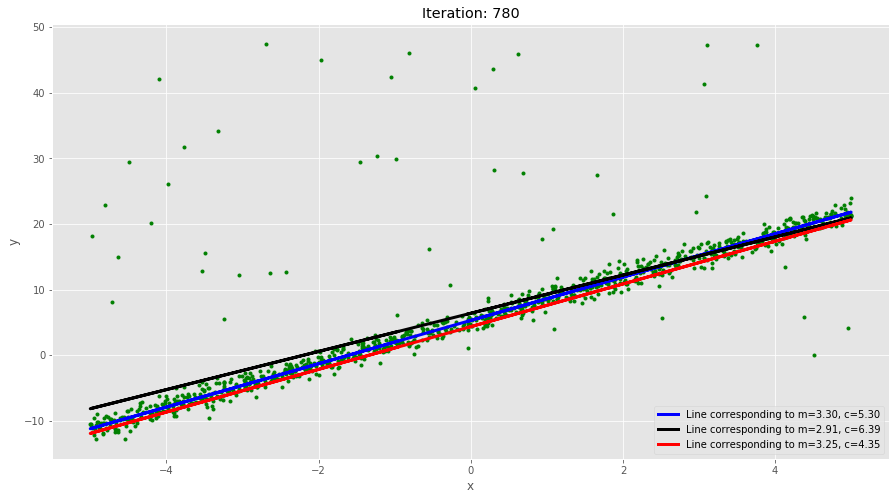

Iteration: 800, 
MSE Loss: 33.564, m_mse: 3.163, m_mse: 6.268
Iteration: 800, 
MAE Loss: 2.162, m_mae: 3.268, m_mae: 4.423


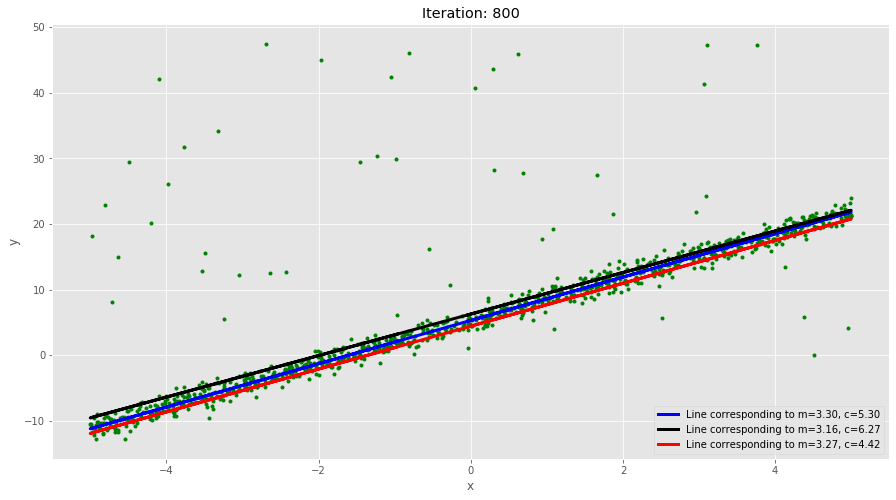

Iteration: 840, 
MSE Loss: 34.554, m_mse: 3.415, m_mse: 6.305
Iteration: 840, 
MAE Loss: 2.080, m_mae: 3.273, m_mae: 4.551


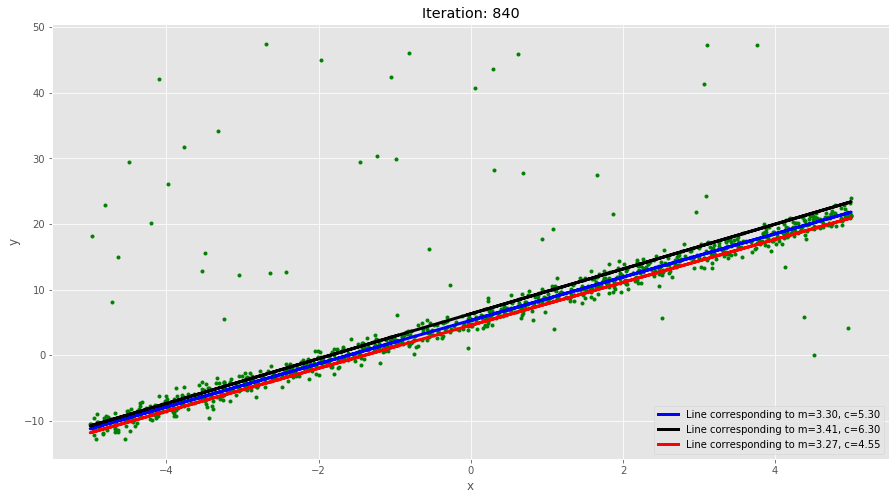

Iteration: 880, 
MSE Loss: 33.535, m_mse: 3.145, m_mse: 6.299
Iteration: 880, 
MAE Loss: 2.013, m_mae: 3.262, m_mae: 4.669


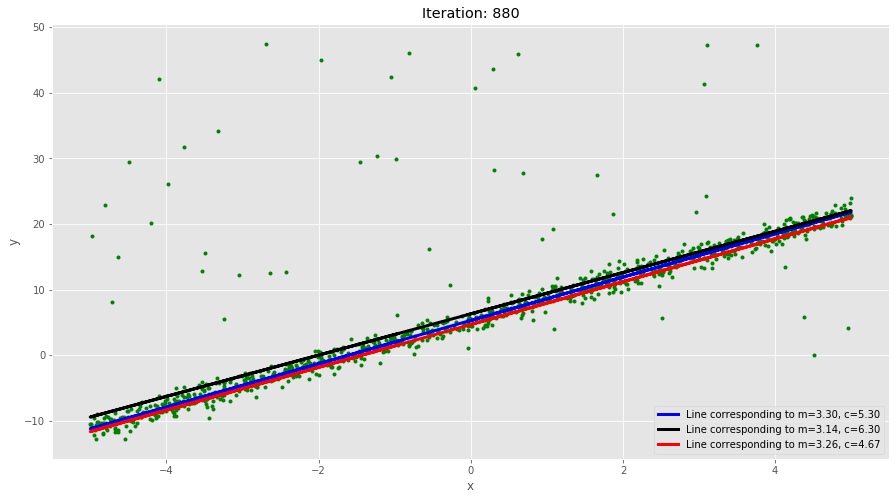

Iteration: 900, 
MSE Loss: 33.473, m_mse: 3.051, m_mse: 6.286
Iteration: 900, 
MAE Loss: 1.986, m_mae: 3.267, m_mae: 4.722


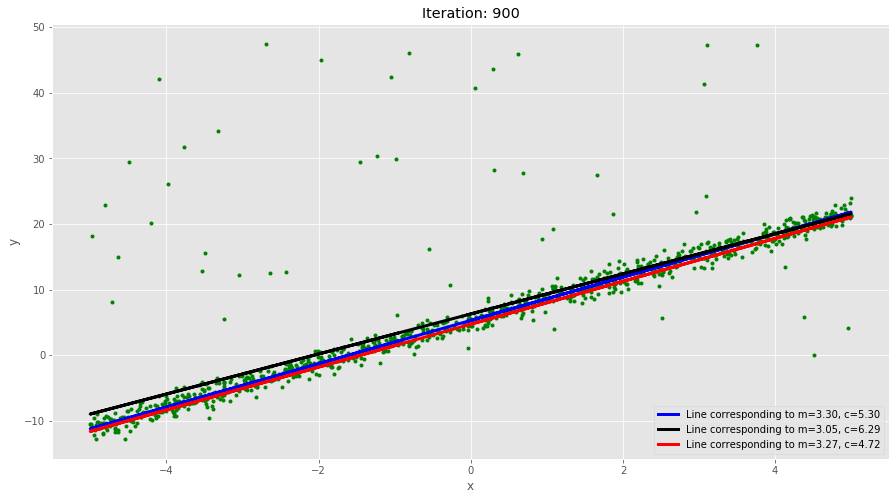

Iteration: 940, 
MSE Loss: 33.535, m_mse: 3.002, m_mse: 6.459
Iteration: 940, 
MAE Loss: 1.949, m_mae: 3.230, m_mae: 4.823


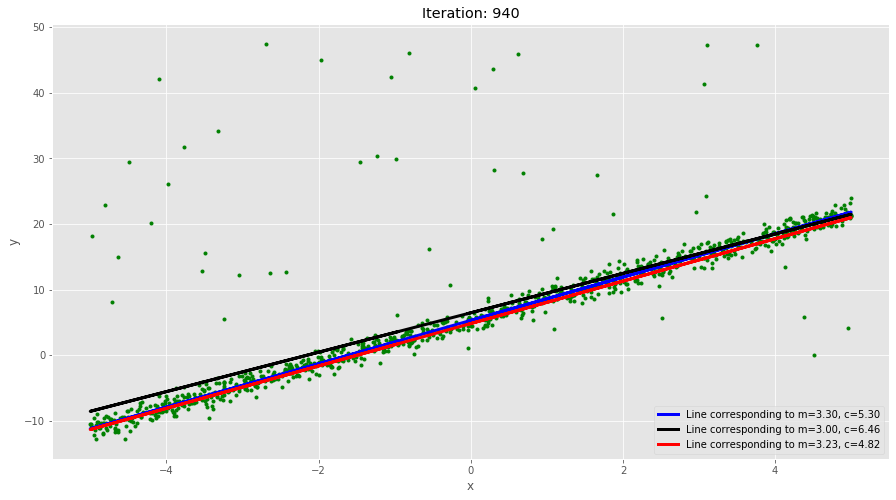

Iteration: 980, 
MSE Loss: 33.497, m_mse: 3.040, m_mse: 6.420
Iteration: 980, 
MAE Loss: 1.915, m_mae: 3.279, m_mae: 4.890


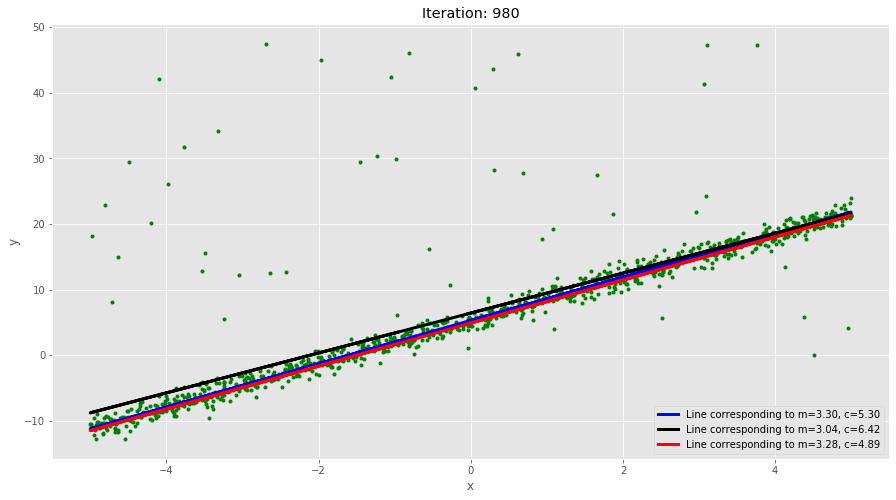

Iteration: 1000, 
MSE Loss: 33.595, m_mse: 3.169, m_mse: 6.414
Iteration: 1000, 
MAE Loss: 1.905, m_mae: 3.307, m_mae: 4.929


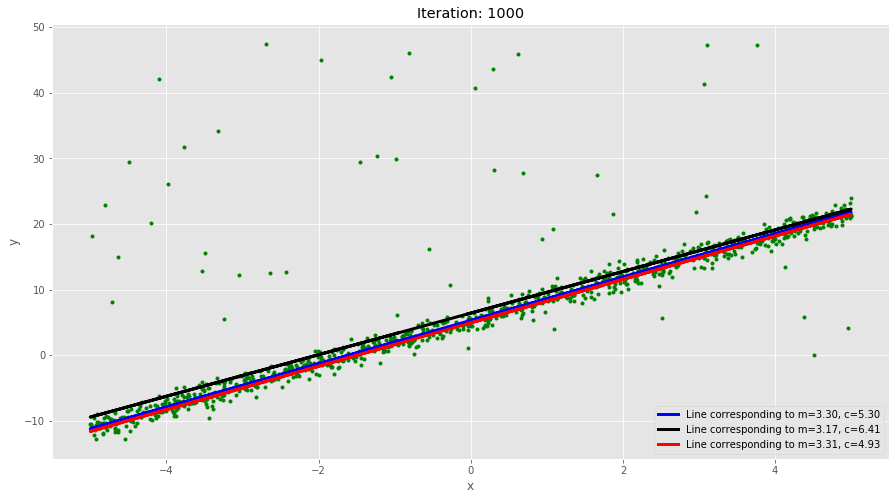

Iteration: 1040, 
MSE Loss: 34.150, m_mse: 3.339, m_mse: 6.364
Iteration: 1040, 
MAE Loss: 1.886, m_mae: 3.279, m_mae: 4.986


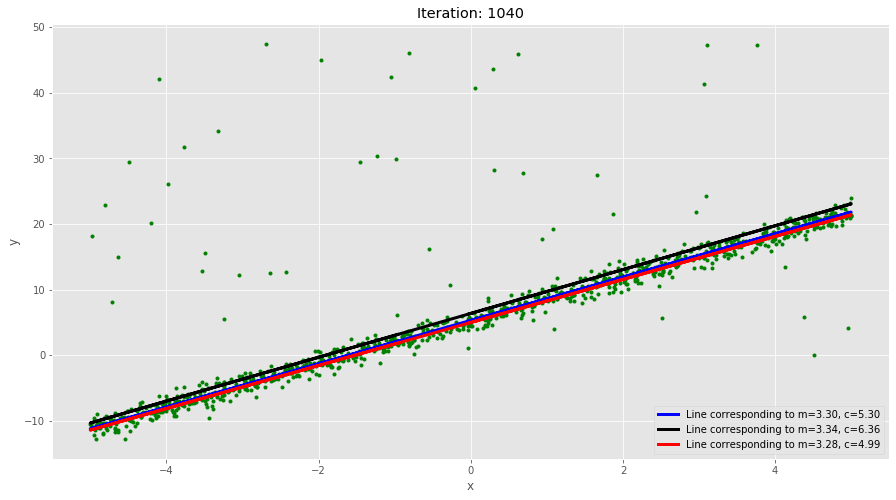

Iteration: 1080, 
MSE Loss: 33.668, m_mse: 3.207, m_mse: 6.372
Iteration: 1080, 
MAE Loss: 1.871, m_mae: 3.289, m_mae: 5.044


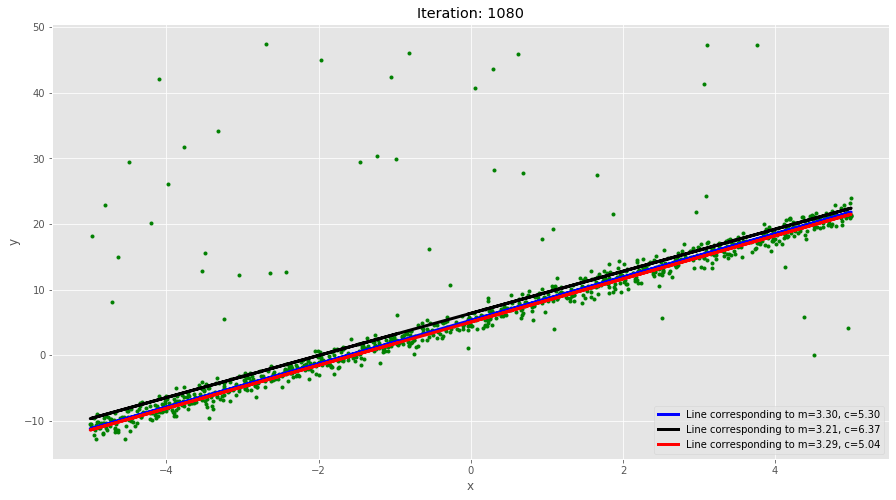

Iteration: 1100, 
MSE Loss: 33.666, m_mse: 3.207, m_mse: 6.358
Iteration: 1100, 
MAE Loss: 1.866, m_mae: 3.297, m_mae: 5.068


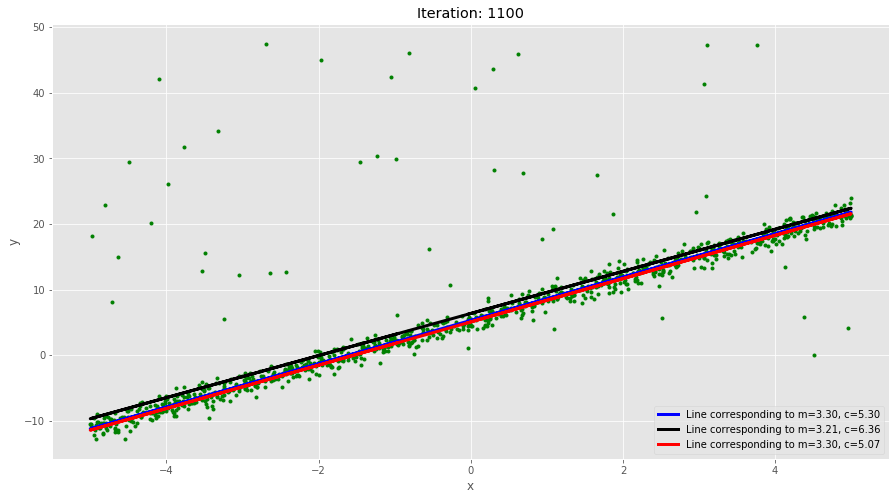

Iteration: 1140, 
MSE Loss: 34.529, m_mse: 2.714, m_mse: 6.454
Iteration: 1140, 
MAE Loss: 1.861, m_mae: 3.253, m_mae: 5.107


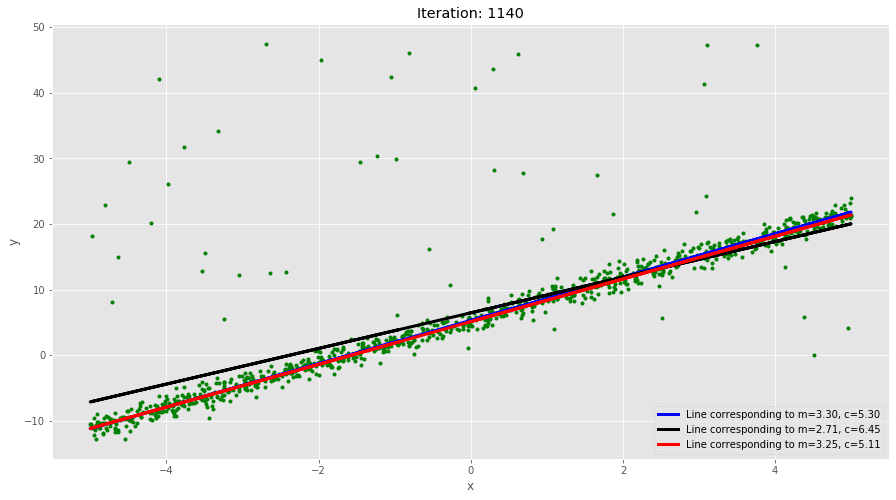

Iteration: 1180, 
MSE Loss: 33.606, m_mse: 3.183, m_mse: 6.335
Iteration: 1180, 
MAE Loss: 1.852, m_mae: 3.308, m_mae: 5.148


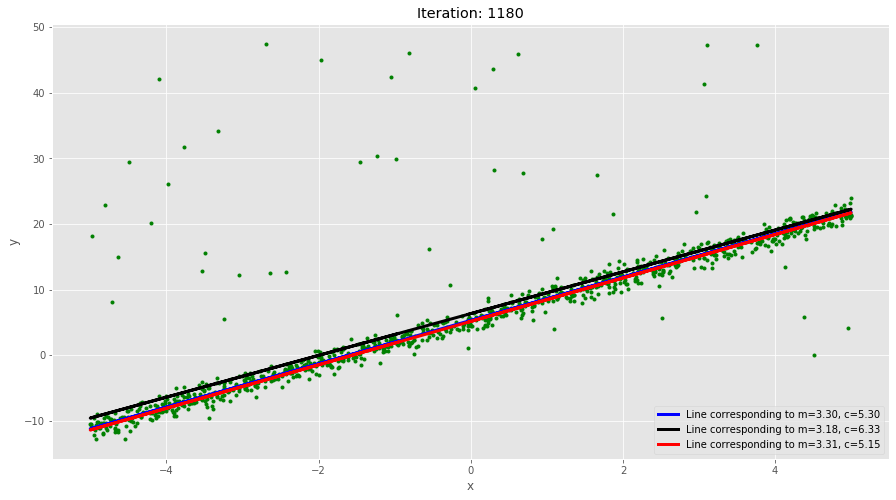

Iteration: 1200, 
MSE Loss: 33.604, m_mse: 3.183, m_mse: 6.306
Iteration: 1200, 
MAE Loss: 1.847, m_mae: 3.293, m_mae: 5.174


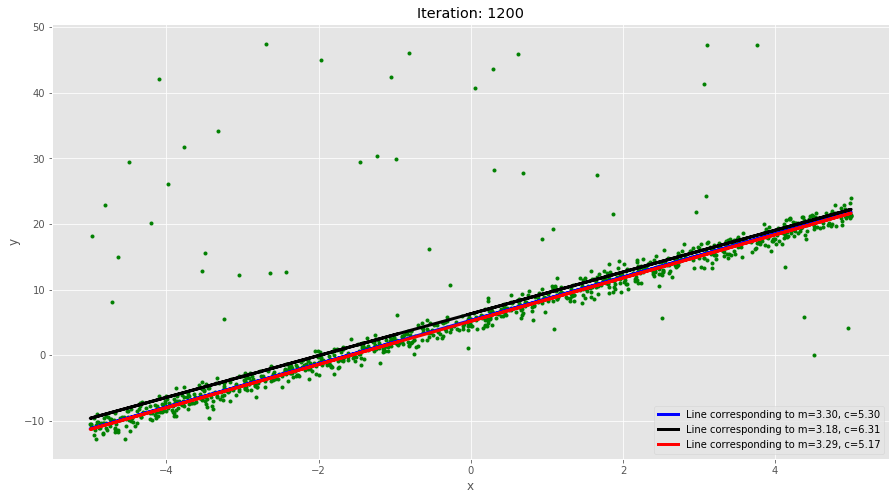

Iteration: 1240, 
MSE Loss: 33.502, m_mse: 3.084, m_mse: 6.428
Iteration: 1240, 
MAE Loss: 1.844, m_mae: 3.311, m_mae: 5.214


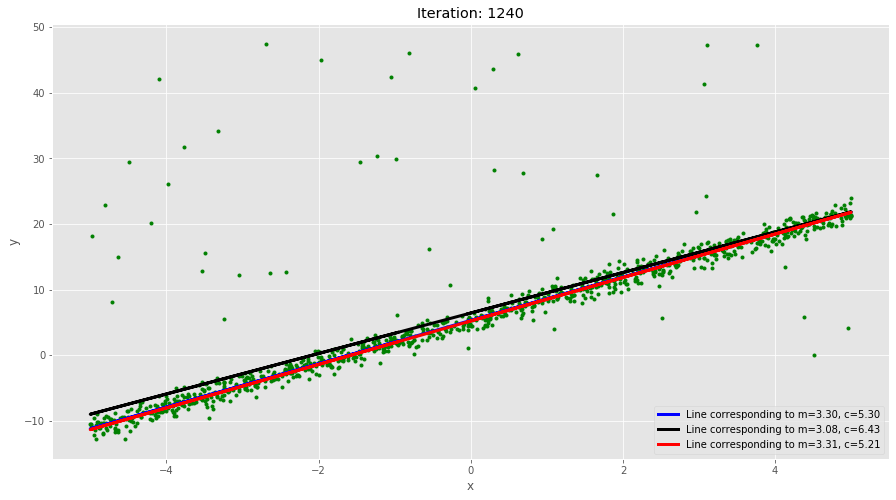

Iteration: 1280, 
MSE Loss: 33.491, m_mse: 3.104, m_mse: 6.232
Iteration: 1280, 
MAE Loss: 1.841, m_mae: 3.284, m_mae: 5.223


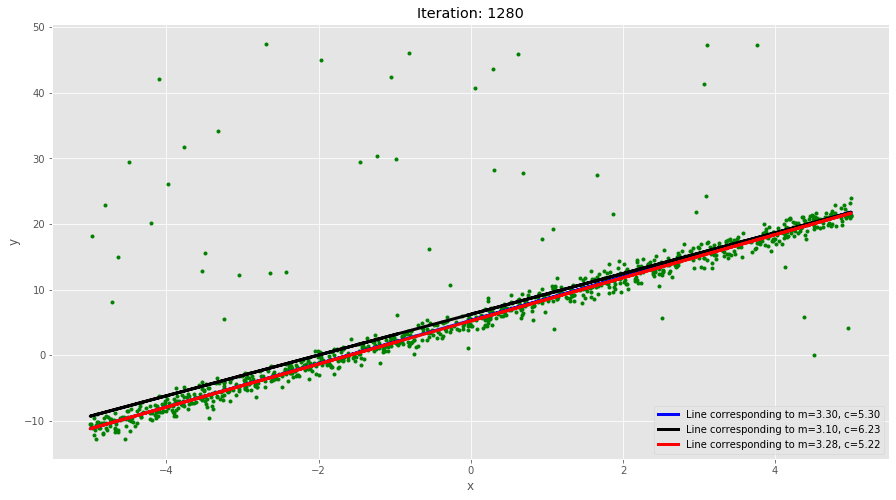

Iteration: 1300, 
MSE Loss: 33.492, m_mse: 3.014, m_mse: 6.238
Iteration: 1300, 
MAE Loss: 1.840, m_mae: 3.302, m_mae: 5.239


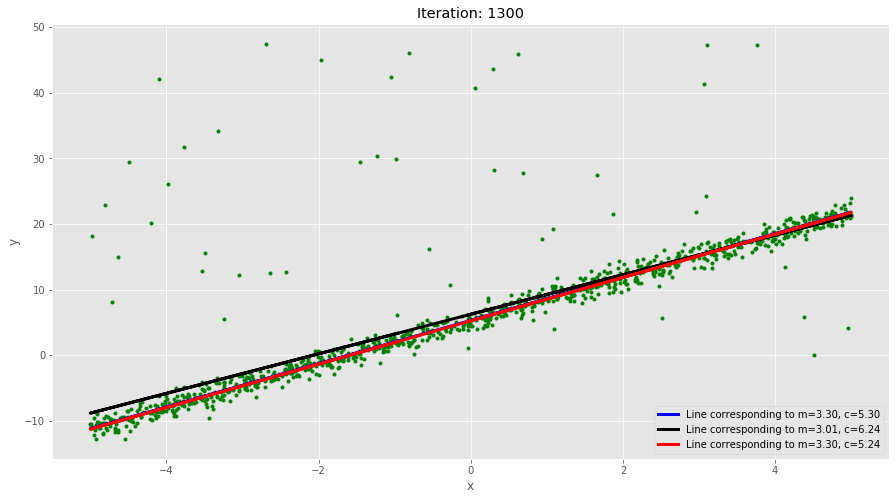

Iteration: 1340, 
MSE Loss: 33.520, m_mse: 2.989, m_mse: 6.337
Iteration: 1340, 
MAE Loss: 1.838, m_mae: 3.274, m_mae: 5.262


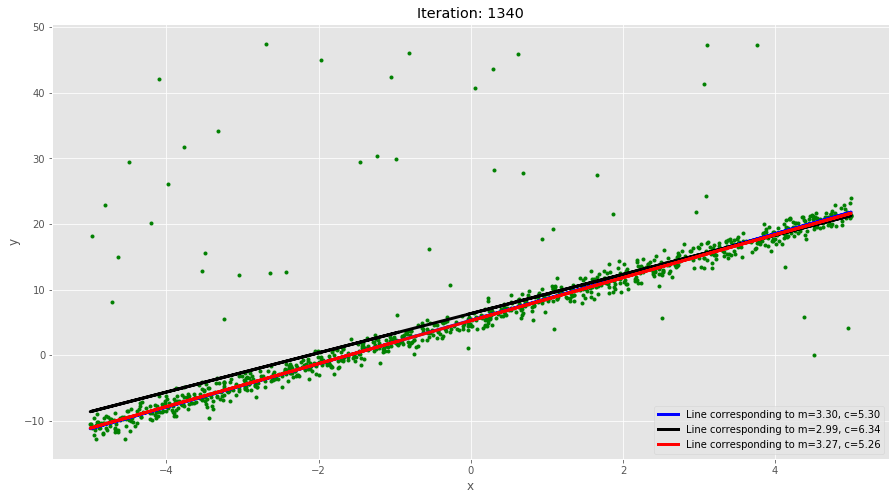

Iteration: 1380, 
MSE Loss: 34.094, m_mse: 3.329, m_mse: 6.292
Iteration: 1380, 
MAE Loss: 1.839, m_mae: 3.304, m_mae: 5.261


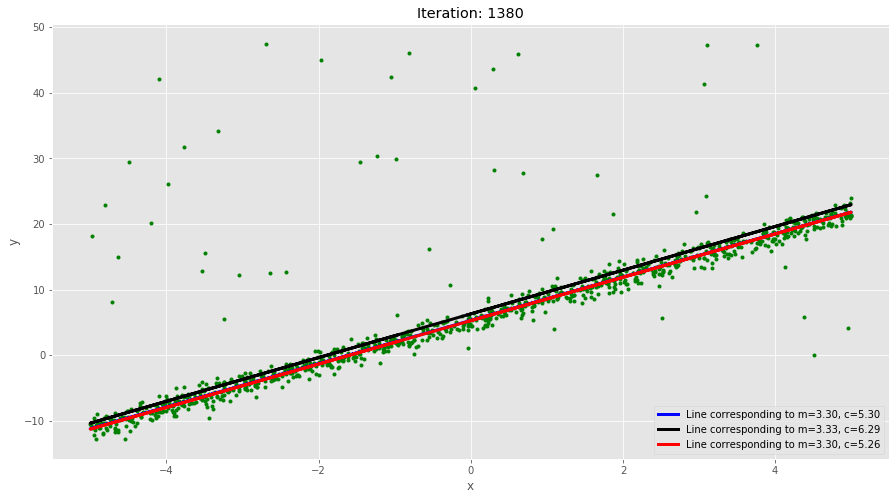

Iteration: 1400, 
MSE Loss: 33.482, m_mse: 3.032, m_mse: 6.221
Iteration: 1400, 
MAE Loss: 1.838, m_mae: 3.293, m_mae: 5.262


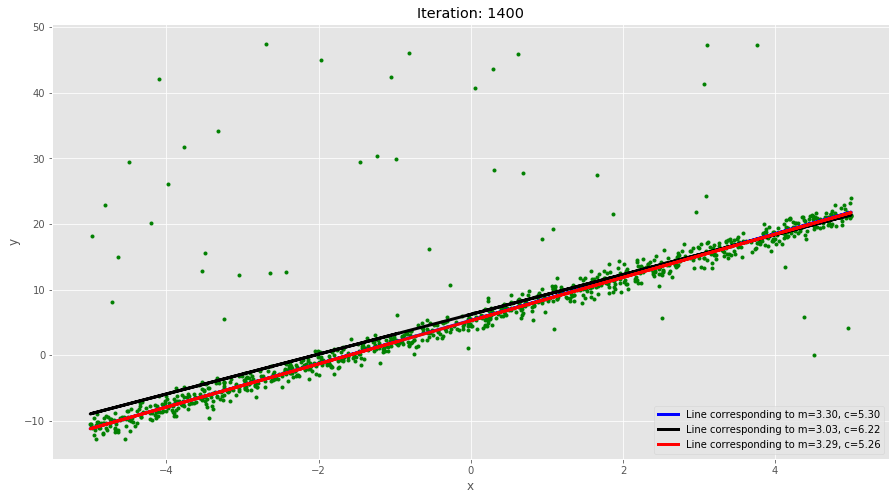

Iteration: 1440, 
MSE Loss: 33.534, m_mse: 3.133, m_mse: 6.149
Iteration: 1440, 
MAE Loss: 1.838, m_mae: 3.298, m_mae: 5.262


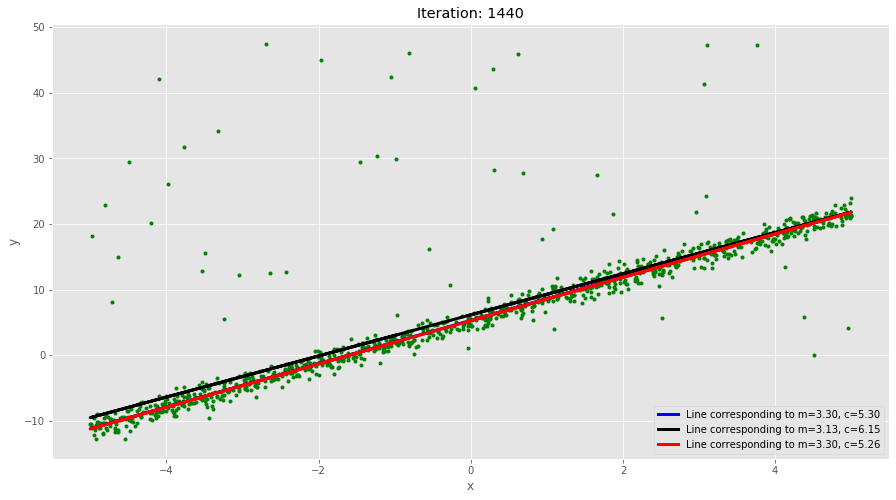

Iteration: 1480, 
MSE Loss: 33.994, m_mse: 2.813, m_mse: 6.274
Iteration: 1480, 
MAE Loss: 1.836, m_mae: 3.283, m_mae: 5.282


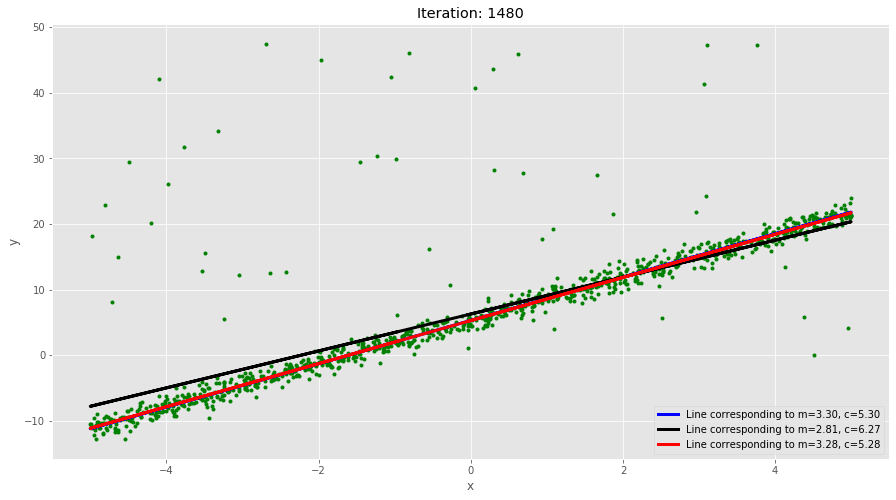

Iteration: 1500, 
MSE Loss: 35.430, m_mse: 2.585, m_mse: 6.432
Iteration: 1500, 
MAE Loss: 1.836, m_mae: 3.289, m_mae: 5.282


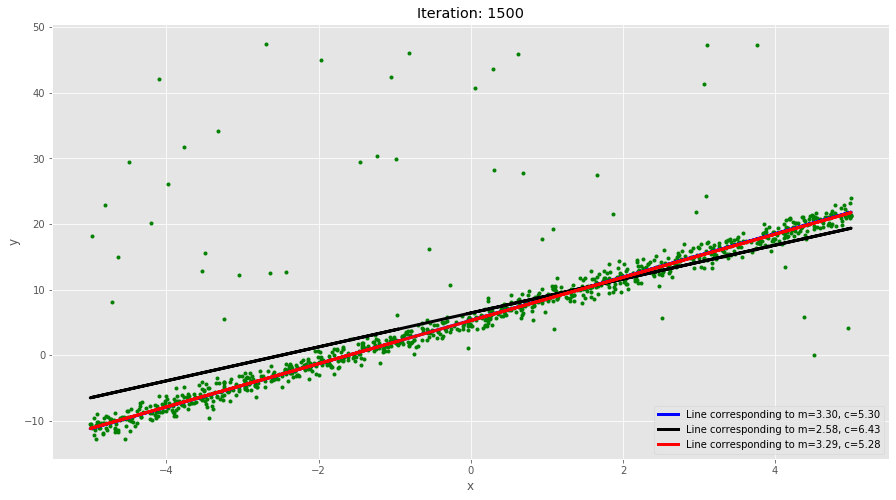

Iteration: 1540, 
MSE Loss: 33.810, m_mse: 2.861, m_mse: 6.286
Iteration: 1540, 
MAE Loss: 1.836, m_mae: 3.270, m_mae: 5.295


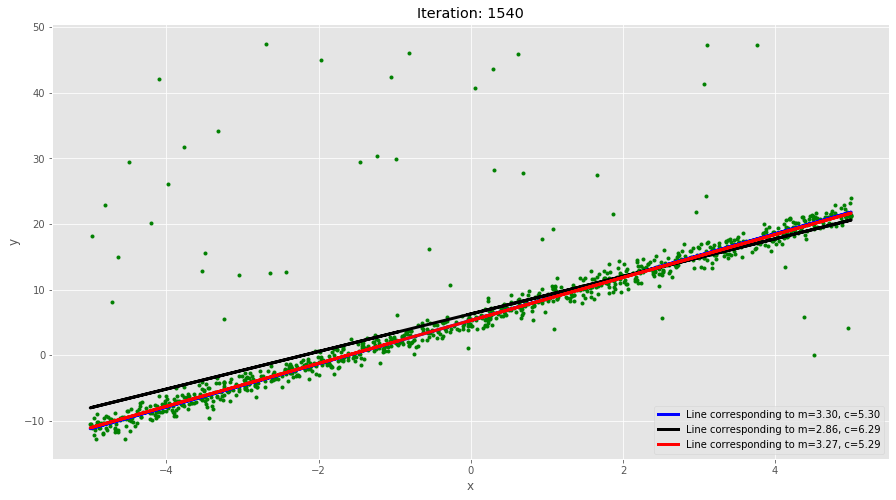

Iteration: 1580, 
MSE Loss: 33.717, m_mse: 2.893, m_mse: 6.194
Iteration: 1580, 
MAE Loss: 1.840, m_mae: 3.245, m_mae: 5.288


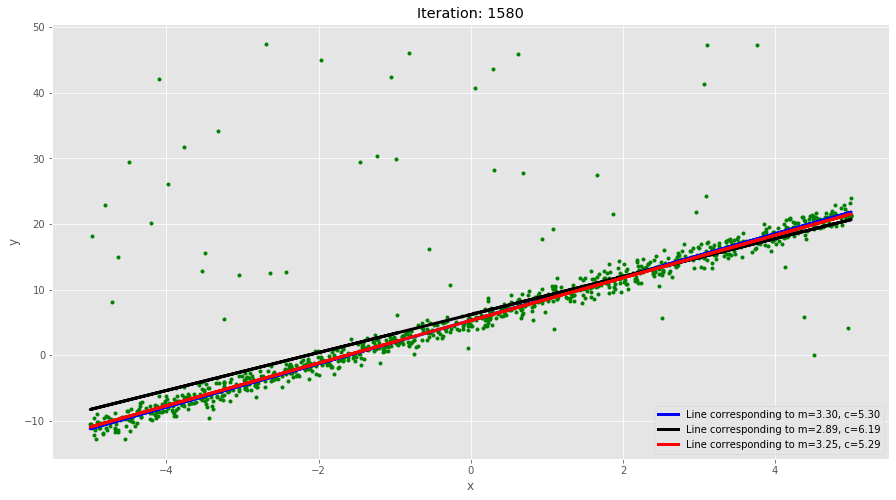

Iteration: 1600, 
MSE Loss: 33.578, m_mse: 2.949, m_mse: 6.246
Iteration: 1600, 
MAE Loss: 1.838, m_mae: 3.251, m_mae: 5.300


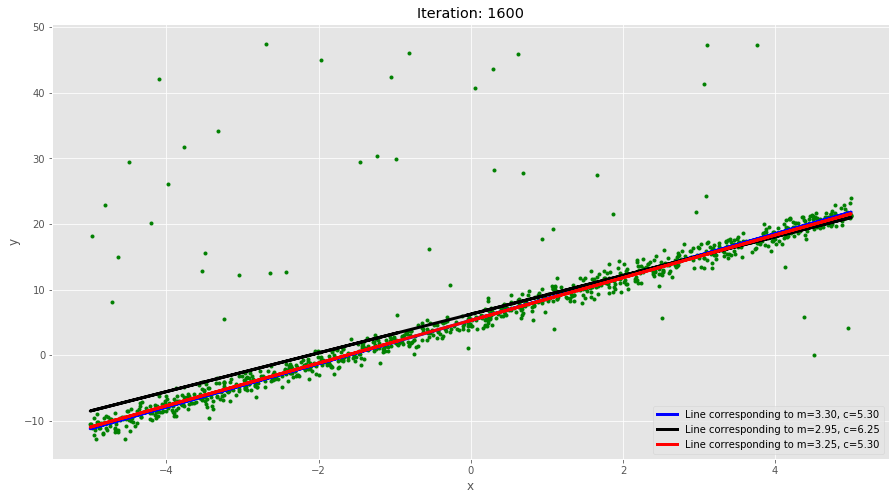

Iteration: 1640, 
MSE Loss: 33.594, m_mse: 3.168, m_mse: 6.127
Iteration: 1640, 
MAE Loss: 1.835, m_mae: 3.289, m_mae: 5.310


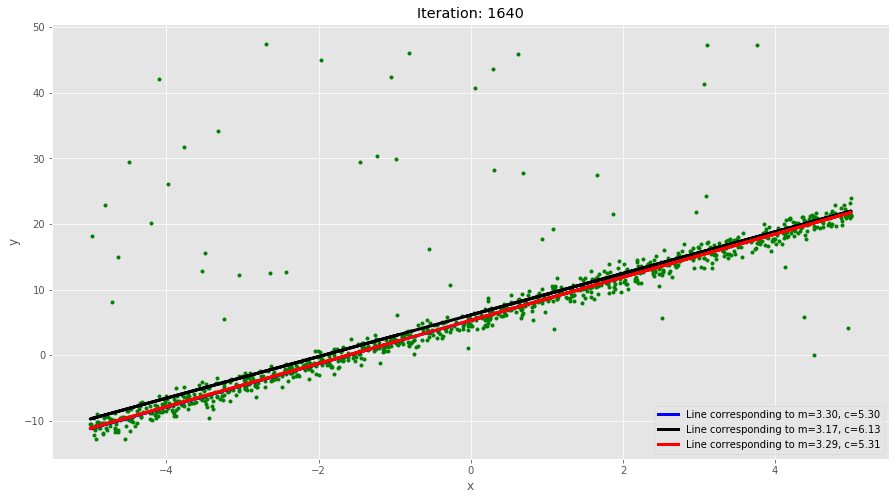

Iteration: 1680, 
MSE Loss: 33.670, m_mse: 3.185, m_mse: 6.019
Iteration: 1680, 
MAE Loss: 1.835, m_mae: 3.283, m_mae: 5.309


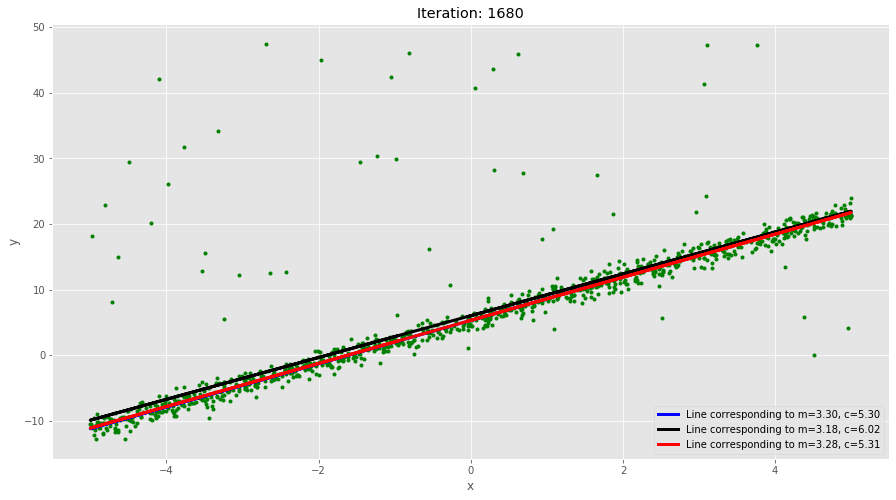

Iteration: 1700, 
MSE Loss: 33.633, m_mse: 3.191, m_mse: 6.156
Iteration: 1700, 
MAE Loss: 1.835, m_mae: 3.289, m_mae: 5.316


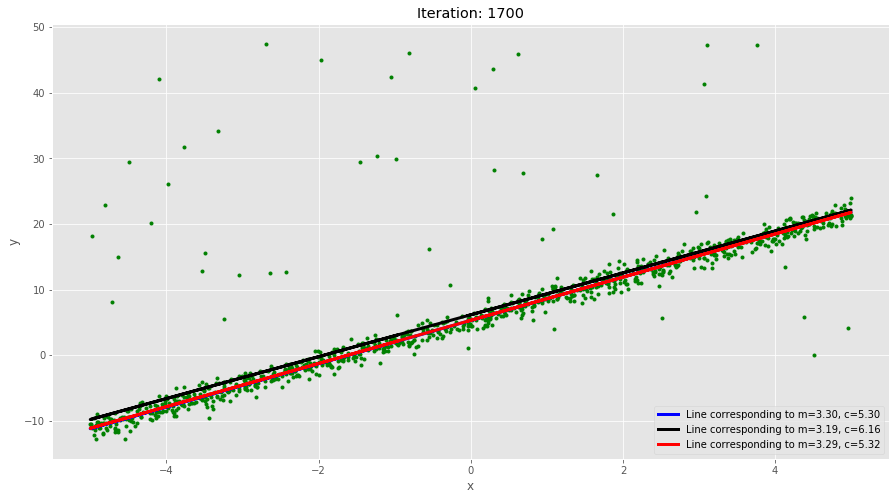

Iteration: 1740, 
MSE Loss: 33.726, m_mse: 3.220, m_mse: 6.092
Iteration: 1740, 
MAE Loss: 1.838, m_mae: 3.308, m_mae: 5.311


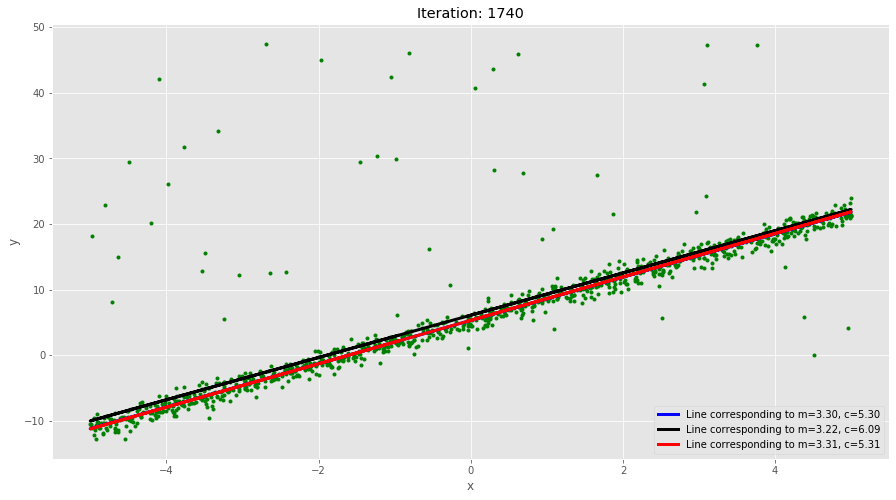

Iteration: 1780, 
MSE Loss: 33.522, m_mse: 3.120, m_mse: 6.140
Iteration: 1780, 
MAE Loss: 1.835, m_mae: 3.289, m_mae: 5.311


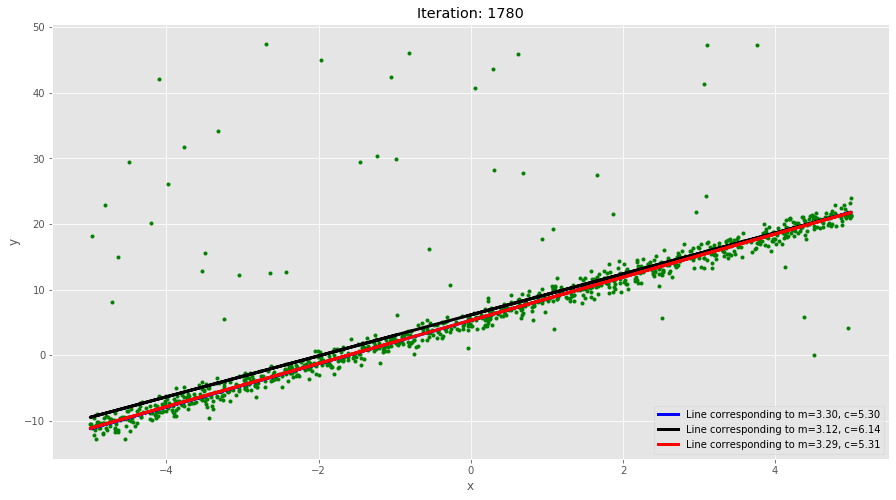

Iteration: 1800, 
MSE Loss: 33.812, m_mse: 3.250, m_mse: 6.106
Iteration: 1800, 
MAE Loss: 1.835, m_mae: 3.288, m_mae: 5.314


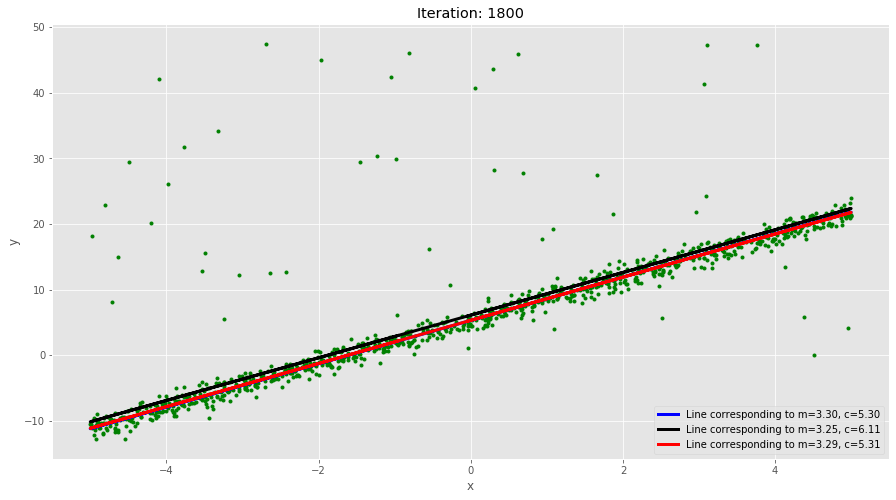

Iteration: 1840, 
MSE Loss: 33.517, m_mse: 2.999, m_mse: 6.160
Iteration: 1840, 
MAE Loss: 1.836, m_mae: 3.259, m_mae: 5.324


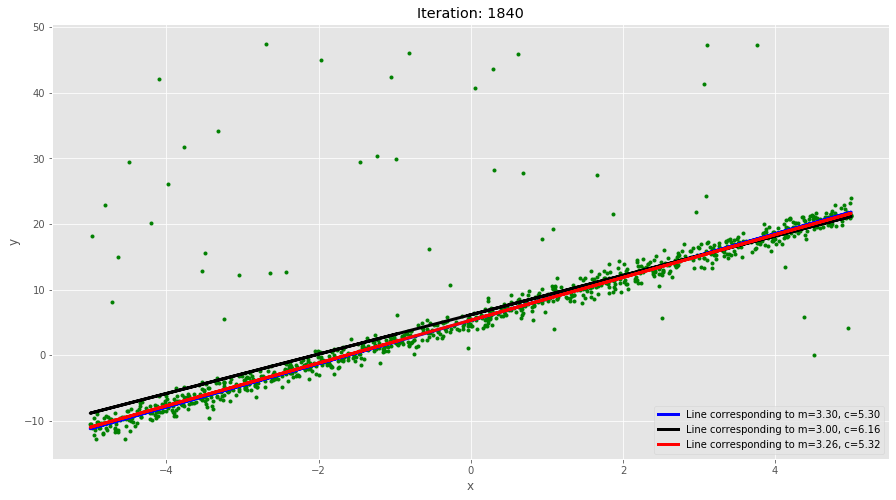

Iteration: 1880, 
MSE Loss: 33.628, m_mse: 2.925, m_mse: 6.283
Iteration: 1880, 
MAE Loss: 1.838, m_mae: 3.250, m_mae: 5.322


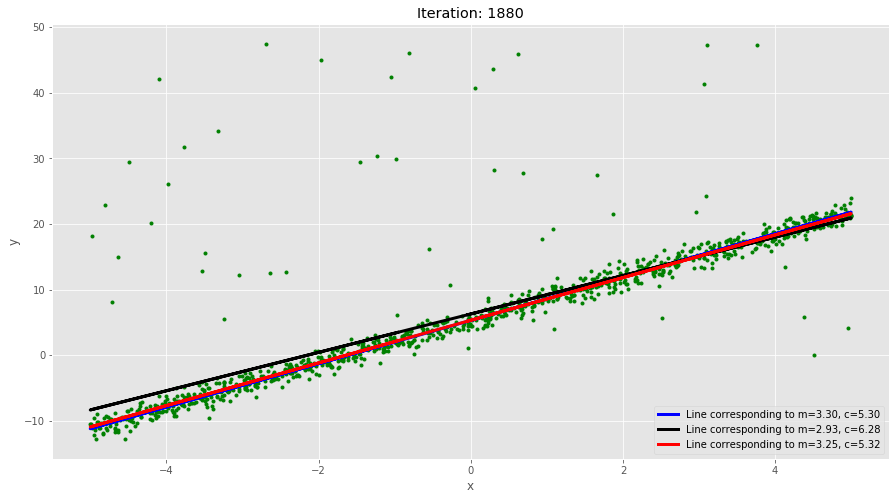

Iteration: 1900, 
MSE Loss: 33.618, m_mse: 2.932, m_mse: 6.203
Iteration: 1900, 
MAE Loss: 1.836, m_mae: 3.263, m_mae: 5.312


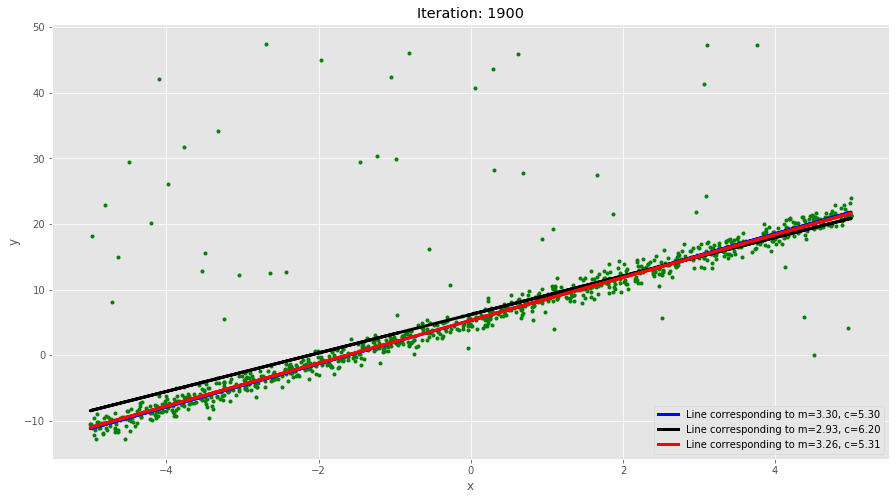

Iteration: 1940, 
MSE Loss: 33.602, m_mse: 2.940, m_mse: 6.359
Iteration: 1940, 
MAE Loss: 1.839, m_mae: 3.244, m_mae: 5.326


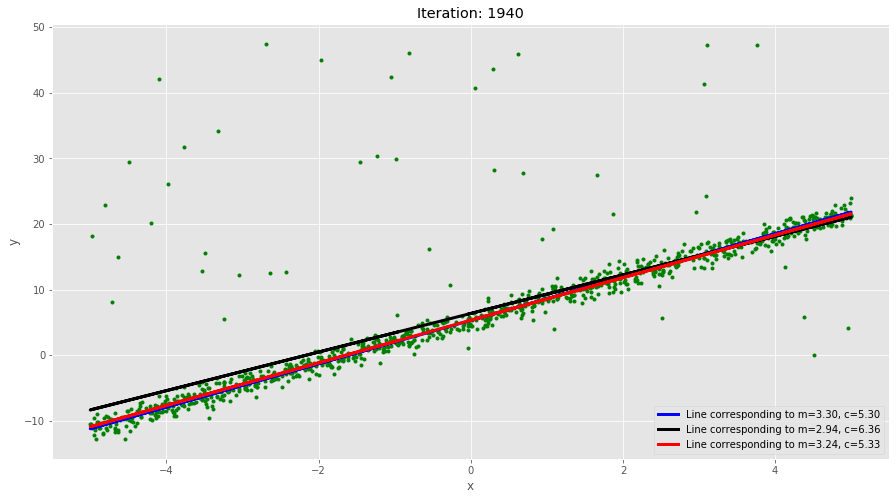

Iteration: 1980, 
MSE Loss: 33.540, m_mse: 3.144, m_mse: 6.353
Iteration: 1980, 
MAE Loss: 1.835, m_mae: 3.289, m_mae: 5.319


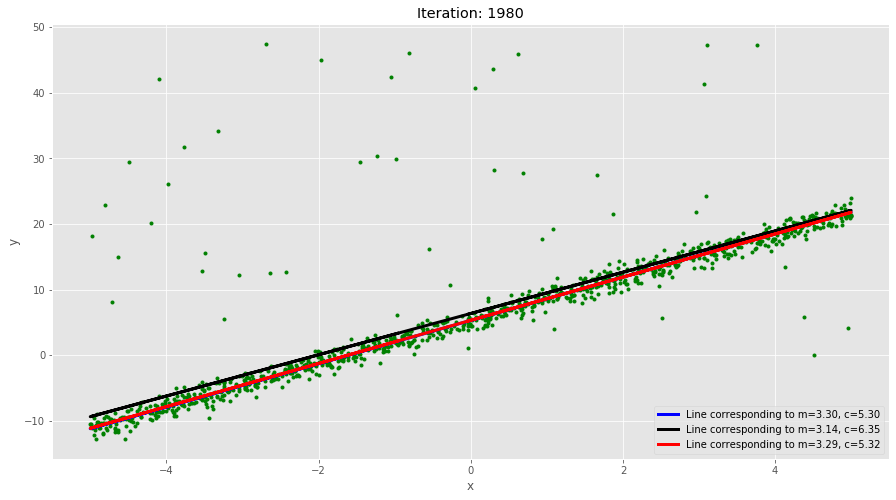

In [16]:
n_epochs = 20
lr = 0.005
batch_size = 10
display_count = 40
initial_m = 2
initial_c = 1

grad_func_list = [gradient_m_and_c_mse, gradient_m_and_c_mae]
loss_func_list = [MSE_loss, MAE_loss]

m, c, loss, final_iteration = train(x, y, y_line, 
                                    initial_m, initial_c, 
                                    grad_func_list, loss_func_list,
                                    lr, batch_size, n_epochs, display_count)

--------------------------
Final plots
--------------------------
Iteration: 1999, 
MSE Loss: 33.576, m_mse: 3.160, m_mse: 6.406
Iteration: 1999, 
MAE Loss: 1.836, m_mae: 3.294, m_mae: 5.325


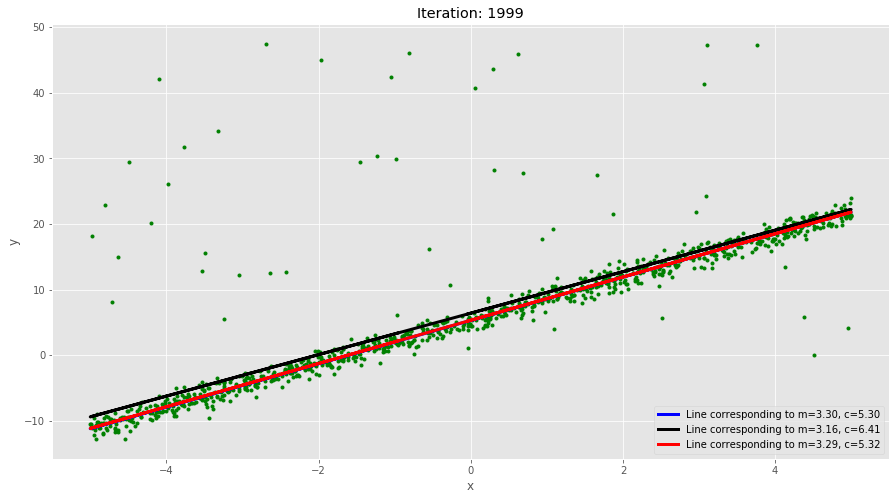

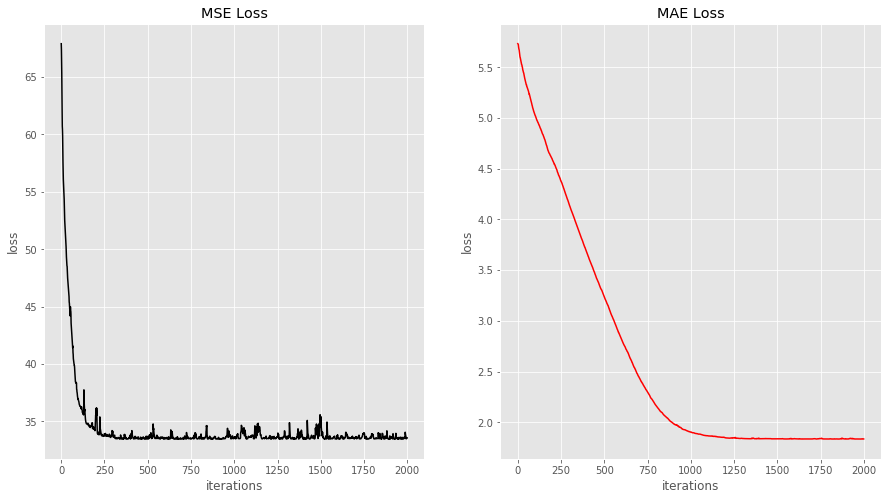

In [17]:
print('{0}\nFinal plots\n{0}'.format('--------------------------'))

display_training(x, y, y_line, loss, m, c, final_iteration)

plot_loss(loss)